In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
from tqdm import tqdm
from numpy import linalg as LA
from scipy import spatial
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [19]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [20]:
train_input = train_input + val_input
train_output = train_output + val_output

In [21]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [22]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [23]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [24]:
train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
test_input = torch.from_numpy(test_input)

train_output = torch.from_numpy(train_output)
val_output = torch.from_numpy(val_output)
test_output = torch.from_numpy(test_output)

In [25]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

torch.Size([66175, 13953])
torch.Size([28921, 13953])
torch.Size([1000, 13953])
torch.Size([66175, 1])
torch.Size([28921, 1])
torch.Size([1000, 1])


In [26]:
def top_samples(source, target, num):
    temp_list = []
    for i in range(target.shape[0]):
        temp_list.append([spatial.distance.cosine(source, target[i]), i])
    temp_list.sort()
    return [ele[1] for ele in temp_list[:num]]

In [27]:
nn_num = 1

In [29]:
input_near_ind_list = []
output_near_ind_list = []

for i in tqdm(range(RNA_s4d9.shape[0])):
    near_neig_ind = top_samples(RNA_s4d9[i], RNA_s3d1, nn_num)
    input_near_ind_list.append(RNA_s3d1[near_neig_ind])
    output_near_ind_list.append(pro_s3d1[near_neig_ind])
    
input_near = np.concatenate(input_near_ind_list, axis= 0)
output_near = np.concatenate(output_near_ind_list, axis= 0)

100%|██████████| 459/459 [15:32<00:00,  2.03s/it]


In [30]:
# with open(r"input_near_cos.pickle", "wb") as output_file:
#     pickle.dump(input_near, output_file)
    
# with open(r"output_near_cos.pickle", "wb") as output_file:
#     pickle.dump(output_near, output_file)

In [31]:
# with open(r"input_near_cos.pickle", "rb") as input_file:
#     input_near = pickle.load(input_file)
    
# with open(r"output_near_cos.pickle", "rb") as input_file:
#     output_near = pickle.load(input_file)

In [32]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [33]:
train_input = train_input.float()
val_input = val_input.float()
test_input = test_input.float()

train_output = train_output.float()
val_output = val_output.float()
test_output = test_output.float()

In [34]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [35]:
train_input = train_input.to(device)
val_input = val_input.to(device)
test_input = test_input.to(device)

train_output = train_output.to(device)
val_output = val_output.to(device)
test_output = test_output.to(device)

In [36]:
input_near = torch.from_numpy(input_near)
output_near = torch.from_numpy(output_near)

In [37]:
input_near = input_near.to(device)
output_near = output_near.to(device)

In [38]:
input_feature = RNA_s1d1.shape[1]

In [39]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [40]:
PATH = 'No_norm_model_RNA_pro'

In [41]:
def fit(num_epochs, model, loss_fn, RNA, pro):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            near_pred = model(input_near)
            near_loss = loss_fn(near_pred, output_near)
            near_loss = torch.sqrt(near_loss)
            near_loss = near_loss.cpu().detach().numpy()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            print('Epoch ', epoch, 'near loss:', near_loss, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 13, figsize = (33, 3))
            for i in range(1):
                
                ax[0].scatter(output_near.cpu().detach().numpy()[:, 0], near_pred.cpu().detach().numpy()[:, 0], c='purple', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Nearest neighbor result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')
                
                ax[1].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d1 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d2 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')

                ax[3].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s1d3 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')
                
                ax[4].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d1 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d4 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')

                ax[6].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s2d5 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')
                
                ax[7].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d1 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d6 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')

                ax[9].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s3d7 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')
                
                ax[10].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d1 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d8 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')

                ax[12].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[12].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[12].set_title('s4d9 result')
                ax[12].set_xlabel('true')
                ax[12].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 near loss: 0.35194278 s1d1:  1.0304383 s1d2:  1.1145458 s1d3:  0.9726498 s2d1: 0.57416266 s2d4: 0.6469441 s2d5: 0.687249 s3d1: 0.2773514 s3d6: 0.68899447 s3d7: 0.81665874 s4d1: 0.8134362 s4d8: 1.0389786 s4d9: 0.46869662 test loss: 0.7384333225435579


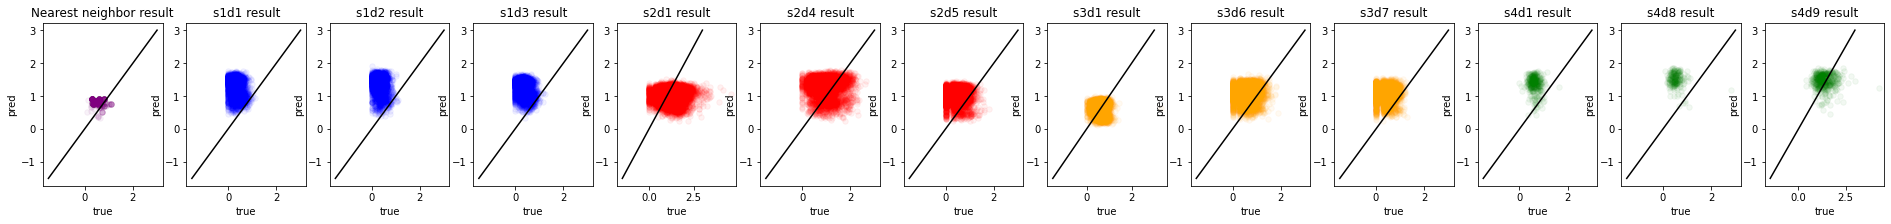

Epoch  100 near loss: 0.035633724 s1d1:  0.5817547 s1d2:  0.5847347 s1d3:  0.52319723 s2d1: 0.73662966 s2d4: 0.4861957 s2d5: 0.3645323 s3d1: 0.22457126 s3d6: 0.38614672 s3d7: 0.4039993 s4d1: 0.3431592 s4d8: 0.5379573 s4d9: 0.5787047 test loss: 0.5029466827039475
Epoch  200 near loss: 0.015948534 s1d1:  0.57366884 s1d2:  0.5765241 s1d3:  0.51439 s2d1: 0.7436533 s2d4: 0.489036 s2d5: 0.36377156 s3d1: 0.22578493 s3d6: 0.38479173 s3d7: 0.3979343 s4d1: 0.33614564 s4d8: 0.52853215 s4d9: 0.581797 test loss: 0.5009296383214052
Epoch  300 near loss: 0.008791418 s1d1:  0.5740272 s1d2:  0.5788338 s1d3:  0.5151826 s2d1: 0.74334216 s2d4: 0.4888124 s2d5: 0.36553964 s3d1: 0.22446613 s3d6: 0.3861116 s3d7: 0.39951113 s4d1: 0.33512327 s4d8: 0.5274057 s4d9: 0.57937825 test loss: 0.49916521997260715
Epoch  400 near loss: 0.005620799 s1d1:  0.57712626 s1d2:  0.5811489 s1d3:  0.518295 s2d1: 0.74049425 s2d4: 0.48761976 s2d5: 0.36707819 s3d1: 0.22220516 s3d6: 0.38798514 s3d7: 0.40213624 s4d1: 0.336114 s4d8: 0.

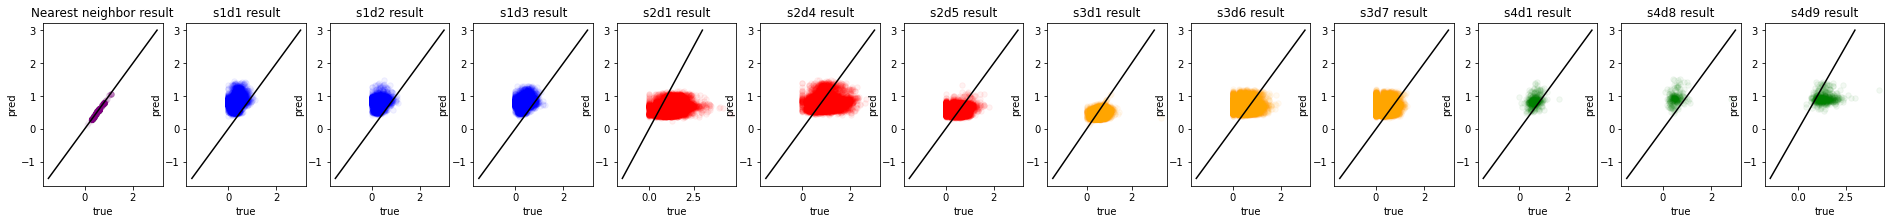

Epoch  1100 near loss: 0.0022601758 s1d1:  0.5526961 s1d2:  0.55298334 s1d3:  0.49568918 s2d1: 0.7466115 s2d4: 0.4905531 s2d5: 0.36164173 s3d1: 0.2168294 s3d6: 0.38114634 s3d7: 0.3927005 s4d1: 0.31235886 s4d8: 0.49686942 s4d9: 0.5944743 test loss: 0.495885271962102
Epoch  1200 near loss: 0.0025156774 s1d1:  0.54940903 s1d2:  0.54925066 s1d3:  0.49281546 s2d1: 0.7475444 s2d4: 0.49072734 s2d5: 0.36083084 s3d1: 0.21612711 s3d6: 0.3799871 s3d7: 0.3913163 s4d1: 0.30895123 s4d8: 0.49212664 s4d9: 0.59752816 test loss: 0.4958779574864485
Epoch  1300 near loss: 0.0017831571 s1d1:  0.5422631 s1d2:  0.54212856 s1d3:  0.4859373 s2d1: 0.75068915 s2d4: 0.49202597 s2d5: 0.358797 s3d1: 0.21618015 s3d6: 0.37748253 s3d7: 0.38802204 s4d1: 0.3031473 s4d8: 0.48494908 s4d9: 0.6026893 test loss: 0.49608464949062814
Epoch  1400 near loss: 0.002483625 s1d1:  0.5428302 s1d2:  0.54210204 s1d3:  0.48682523 s2d1: 0.74940795 s2d4: 0.4919385 s2d5: 0.35954624 s3d1: 0.21509695 s3d6: 0.37836272 s3d7: 0.3888258 s4d1: 0.

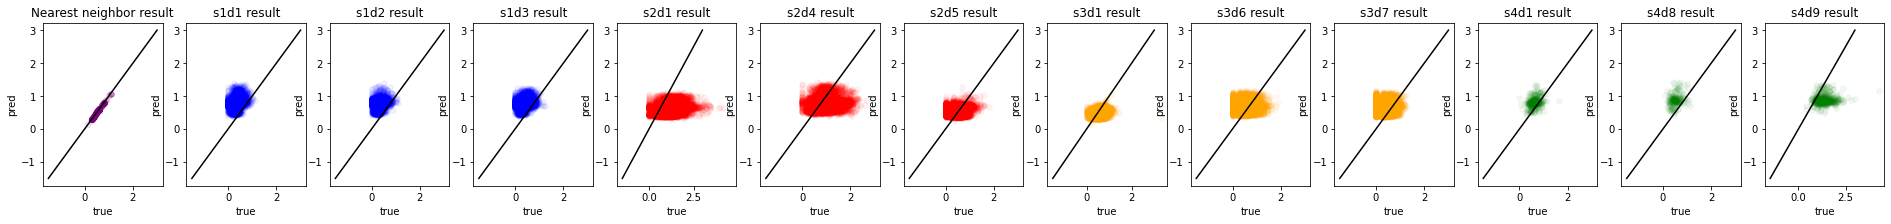

Epoch  2100 near loss: 0.0014874114 s1d1:  0.5166207 s1d2:  0.5134223 s1d3:  0.46316615 s2d1: 0.75877935 s2d4: 0.49802148 s2d5: 0.35319635 s3d1: 0.21295977 s3d6: 0.37016672 s3d7: 0.37671554 s4d1: 0.28055182 s4d8: 0.454451 s4d9: 0.625066 test loss: 0.49837182600377894
Epoch  2200 near loss: 0.0025314202 s1d1:  0.5108961 s1d2:  0.50793815 s1d3:  0.45796683 s2d1: 0.76138675 s2d4: 0.4995083 s2d5: 0.35173446 s3d1: 0.21307231 s3d6: 0.3683055 s3d7: 0.37402642 s4d1: 0.27630535 s4d8: 0.44889513 s4d9: 0.6295961 test loss: 0.49915390566587786
Epoch  2300 near loss: 0.0014346634 s1d1:  0.5100156 s1d2:  0.50635815 s1d3:  0.4575784 s2d1: 0.7612349 s2d4: 0.49990657 s2d5: 0.35188857 s3d1: 0.21251418 s3d6: 0.36826247 s3d7: 0.3734175 s4d1: 0.27531025 s4d8: 0.44709507 s4d9: 0.630507 test loss: 0.4991635695632302
Epoch  2400 near loss: 0.0017909027 s1d1:  0.5081055 s1d2:  0.5049585 s1d3:  0.4557318 s2d1: 0.7614873 s2d4: 0.5006115 s2d5: 0.35220847 s3d1: 0.21199629 s3d6: 0.3682036 s3d7: 0.37321734 s4d1: 0.2

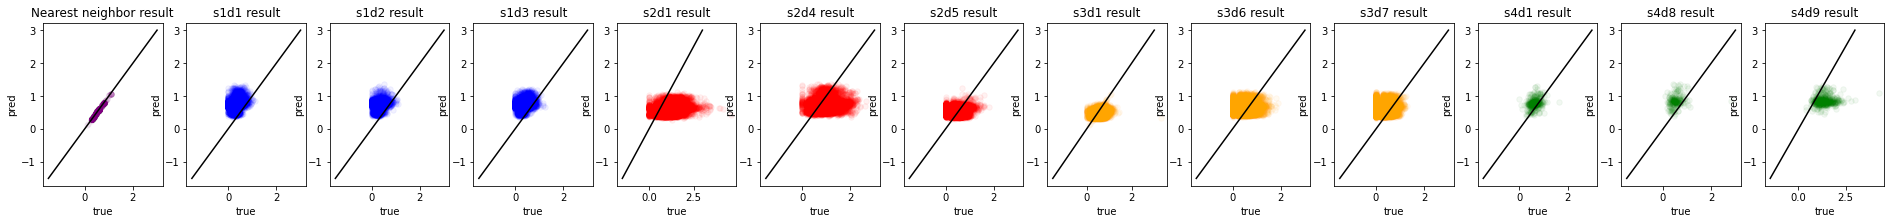

Epoch  3100 near loss: 0.002090862 s1d1:  0.49186596 s1d2:  0.486184 s1d3:  0.44166675 s2d1: 0.76699936 s2d4: 0.5057246 s2d5: 0.3487037 s3d1: 0.21011093 s3d6: 0.36356297 s3d7: 0.36553112 s4d1: 0.26064238 s4d8: 0.42604327 s4d9: 0.6472324 test loss: 0.5025364292696991
Epoch  3200 near loss: 0.0014558759 s1d1:  0.48506042 s1d2:  0.47978255 s1d3:  0.4354593 s2d1: 0.77044046 s2d4: 0.5079785 s2d5: 0.3469535 s3d1: 0.21050204 s3d6: 0.36137506 s3d7: 0.36224604 s4d1: 0.25604758 s4d8: 0.41979825 s4d9: 0.6526307 test loss: 0.5038623766318624
Epoch  3300 near loss: 0.0020350532 s1d1:  0.48216036 s1d2:  0.4766784 s1d3:  0.43280235 s2d1: 0.7716004 s2d4: 0.5091723 s2d5: 0.34637648 s3d1: 0.2104975 s3d6: 0.3606319 s3d7: 0.3607757 s4d1: 0.25389677 s4d8: 0.4166636 s4d9: 0.6552238 test loss: 0.5045045722507546
Epoch  3400 near loss: 0.000915839 s1d1:  0.48082754 s1d2:  0.47457463 s1d3:  0.43174976 s2d1: 0.7719236 s2d4: 0.5097344 s2d5: 0.34620893 s3d1: 0.2102031 s3d6: 0.36052892 s3d7: 0.3601158 s4d1: 0.2529

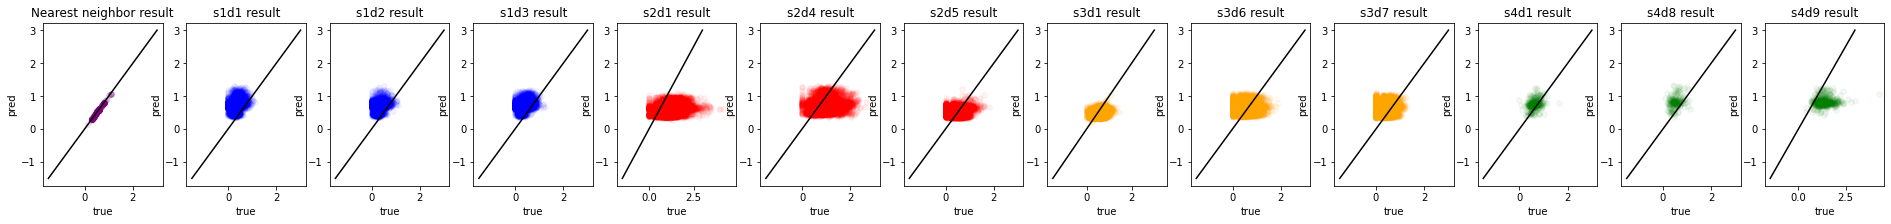

Epoch  4100 near loss: 0.0010414742 s1d1:  0.46591762 s1d2:  0.45821866 s1d3:  0.4182626 s2d1: 0.777743 s2d4: 0.5157689 s2d5: 0.34309396 s3d1: 0.20918694 s3d6: 0.35680076 s3d7: 0.35331696 s4d1: 0.24263778 s4d8: 0.39959732 s4d9: 0.67092496 test loss: 0.509245872468776
Epoch  4200 near loss: 0.0012726316 s1d1:  0.46228912 s1d2:  0.45433307 s1d3:  0.41508937 s2d1: 0.77904123 s2d4: 0.51722085 s2d5: 0.3422894 s3d1: 0.20919989 s3d6: 0.35588655 s3d7: 0.35182706 s4d1: 0.24023315 s4d8: 0.39604506 s4d9: 0.67431545 test loss: 0.5103449909883495
Epoch  4300 near loss: 0.0008460937 s1d1:  0.46287003 s1d2:  0.45490474 s1d3:  0.4158426 s2d1: 0.7784714 s2d4: 0.51687074 s2d5: 0.34267533 s3d1: 0.20879632 s3d6: 0.35609123 s3d7: 0.3521174 s4d1: 0.24028638 s4d8: 0.39578775 s4d9: 0.6741453 test loss: 0.510208824378341
Epoch  4400 near loss: 0.0015812836 s1d1:  0.46231803 s1d2:  0.4546227 s1d3:  0.41560444 s2d1: 0.7783192 s2d4: 0.5170568 s2d5: 0.342997 s3d1: 0.20845397 s3d6: 0.35621002 s3d7: 0.3522397 s4d1: 

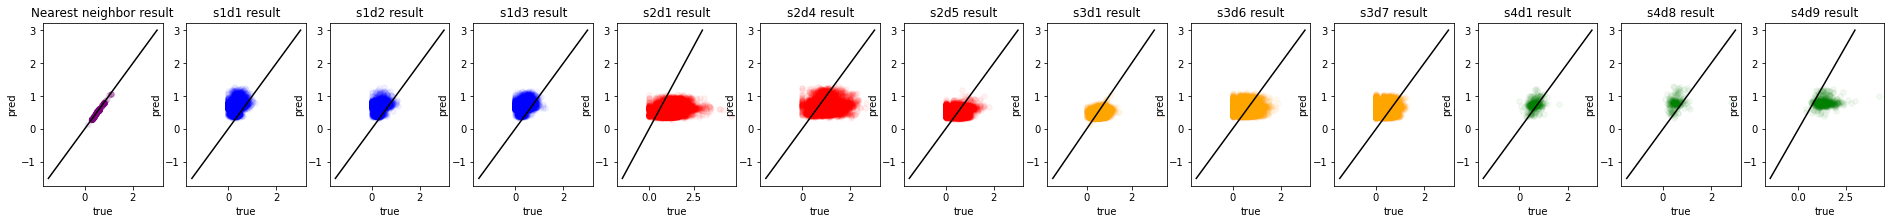

Epoch  5100 near loss: 0.0011683549 s1d1:  0.44899797 s1d2:  0.43958533 s1d3:  0.4036414 s2d1: 0.78452903 s2d4: 0.52302736 s2d5: 0.3397754 s3d1: 0.20816942 s3d6: 0.35264978 s3d7: 0.34559792 s4d1: 0.23110151 s4d8: 0.38118935 s4d9: 0.6881522 test loss: 0.5150509445879781
Epoch  5200 near loss: 0.0010831795 s1d1:  0.44904482 s1d2:  0.4401646 s1d3:  0.40395156 s2d1: 0.7838915 s2d4: 0.5229604 s2d5: 0.34042358 s3d1: 0.20786561 s3d6: 0.3531049 s3d7: 0.3461063 s4d1: 0.23175603 s4d8: 0.38214982 s4d9: 0.68722445 test loss: 0.5147278266419915
Epoch  5300 near loss: 0.0014427301 s1d1:  0.44815558 s1d2:  0.4386903 s1d3:  0.40326017 s2d1: 0.784076 s2d4: 0.5235088 s2d5: 0.34033957 s3d1: 0.20770653 s3d6: 0.35289857 s3d7: 0.34546983 s4d1: 0.2309849 s4d8: 0.38039243 s4d9: 0.6886229 test loss: 0.5152002521332755
Epoch  5400 near loss: 0.0012170501 s1d1:  0.4465737 s1d2:  0.43664637 s1d3:  0.40182742 s2d1: 0.7848757 s2d4: 0.5242656 s2d5: 0.33979332 s3d1: 0.20767403 s3d6: 0.3523984 s3d7: 0.34459758 s4d1: 0

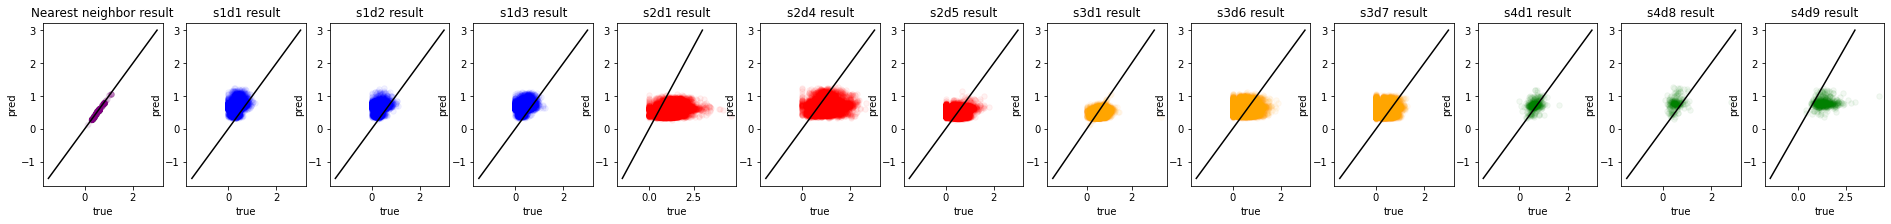

Epoch  6100 near loss: 0.00093035196 s1d1:  0.4375887 s1d2:  0.42709735 s1d3:  0.3940386 s2d1: 0.78867924 s2d4: 0.5285645 s2d5: 0.33828732 s3d1: 0.20742327 s3d6: 0.35057604 s3d7: 0.34055674 s4d1: 0.2247491 s4d8: 0.36978844 s4d9: 0.6990279 test loss: 0.5190979947468386
Epoch  6200 near loss: 0.0011034478 s1d1:  0.43757105 s1d2:  0.42724285 s1d3:  0.39396787 s2d1: 0.78863543 s2d4: 0.52875406 s2d5: 0.33847415 s3d1: 0.20727564 s3d6: 0.35060823 s3d7: 0.34052068 s4d1: 0.22470452 s4d8: 0.36969253 s4d9: 0.6991853 test loss: 0.519174706773328
Epoch  6300 near loss: 0.0012910065 s1d1:  0.43456516 s1d2:  0.423694 s1d3:  0.3912274 s2d1: 0.79025954 s2d4: 0.5301044 s2d5: 0.337487 s3d1: 0.20744894 s3d6: 0.34961265 s3d7: 0.3388795 s4d1: 0.22281013 s4d8: 0.36643428 s4d9: 0.7024311 test loss: 0.5204333532800254
Epoch  6400 near loss: 0.0009948753 s1d1:  0.43531835 s1d2:  0.42463535 s1d3:  0.39210442 s2d1: 0.78949136 s2d4: 0.52991486 s2d5: 0.33806643 s3d1: 0.20720537 s3d6: 0.35026464 s3d7: 0.33949456 s4d

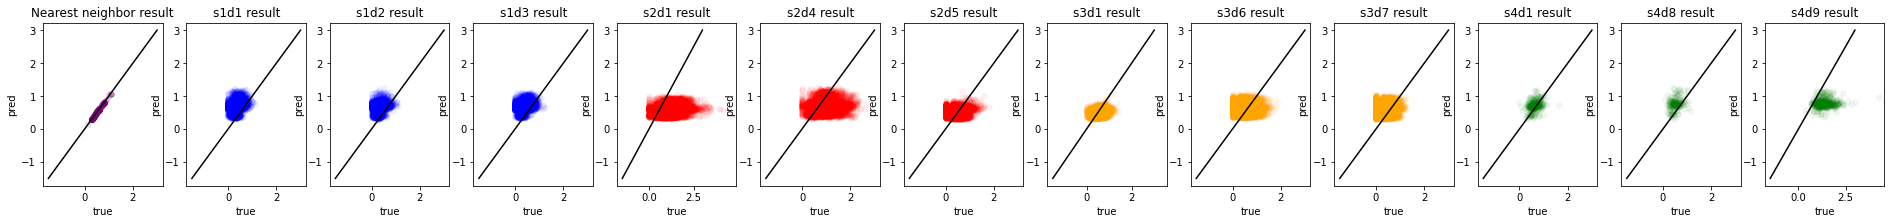

Epoch  7100 near loss: 0.0015021624 s1d1:  0.43079305 s1d2:  0.4193984 s1d3:  0.38860685 s2d1: 0.79123515 s2d4: 0.53227866 s2d5: 0.33743218 s3d1: 0.20676422 s3d6: 0.34919614 s3d7: 0.33727488 s4d1: 0.22076865 s4d8: 0.3619916 s4d9: 0.7065035 test loss: 0.5220269901341033
Epoch  7200 near loss: 0.0014603691 s1d1:  0.42935643 s1d2:  0.41812575 s1d3:  0.38732764 s2d1: 0.7917958 s2d4: 0.5328496 s2d5: 0.3372912 s3d1: 0.20676264 s3d6: 0.3489265 s3d7: 0.33680338 s4d1: 0.22018315 s4d8: 0.36110964 s4d9: 0.7075691 test loss: 0.5224802094443525
Epoch  7300 near loss: 0.0008698339 s1d1:  0.42760116 s1d2:  0.41553408 s1d3:  0.38568896 s2d1: 0.79283357 s2d4: 0.533982 s2d5: 0.3364941 s3d1: 0.20692608 s3d6: 0.34831384 s3d7: 0.33560535 s4d1: 0.21879235 s4d8: 0.35849804 s4d9: 0.71034724 test loss: 0.5236417685670881
Epoch  7400 near loss: 0.00087539194 s1d1:  0.42717445 s1d2:  0.4154767 s1d3:  0.38536897 s2d1: 0.7931623 s2d4: 0.5341473 s2d5: 0.33659148 s3d1: 0.20690642 s3d6: 0.3482953 s3d7: 0.33555582 s4d

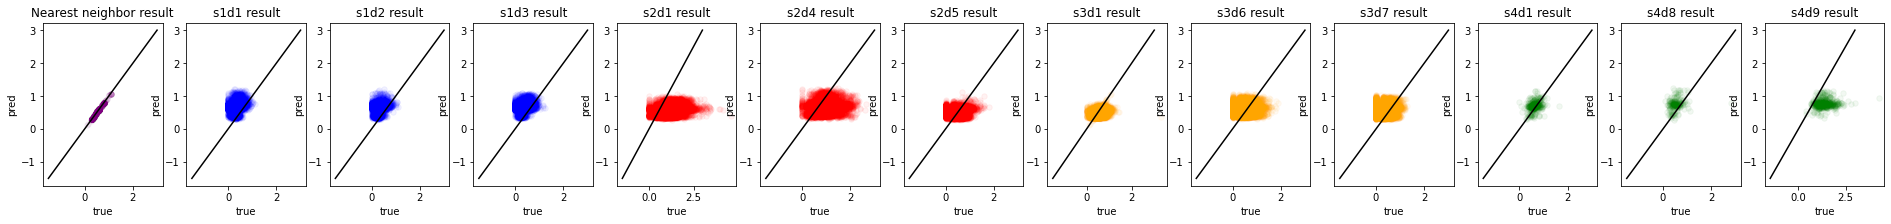

Epoch  8100 near loss: 0.00074595254 s1d1:  0.4211985 s1d2:  0.408843 s1d3:  0.38024196 s2d1: 0.7959679 s2d4: 0.5374778 s2d5: 0.3356125 s3d1: 0.20694016 s3d6: 0.3471394 s3d7: 0.3327017 s4d1: 0.21589333 s4d8: 0.3529057 s4d9: 0.71629846 test loss: 0.5261685158467275
Epoch  8200 near loss: 0.0009228052 s1d1:  0.42204872 s1d2:  0.4094817 s1d3:  0.38095406 s2d1: 0.7952746 s2d4: 0.5370043 s2d5: 0.33571985 s3d1: 0.2066623 s3d6: 0.34732878 s3d7: 0.33317152 s4d1: 0.21598314 s4d8: 0.35304567 s4d9: 0.71601874 test loss: 0.5260255120805845
Epoch  8300 near loss: 0.0013909116 s1d1:  0.419656 s1d2:  0.40695643 s1d3:  0.37887374 s2d1: 0.7966286 s2d4: 0.538116 s2d5: 0.3350858 s3d1: 0.20687577 s3d6: 0.34658578 s3d7: 0.33194238 s4d1: 0.21464778 s4d8: 0.3506272 s4d9: 0.7184841 test loss: 0.5270500599275028
Epoch  8400 near loss: 0.0012457765 s1d1:  0.41986388 s1d2:  0.40742448 s1d3:  0.37902892 s2d1: 0.79648626 s2d4: 0.53808385 s2d5: 0.3353647 s3d1: 0.20685907 s3d6: 0.34673956 s3d7: 0.33205047 s4d1: 0.21

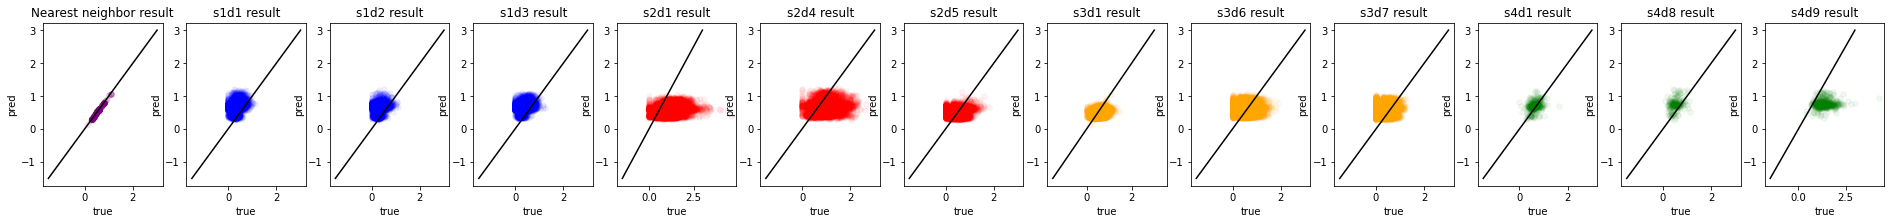

Epoch  9100 near loss: 0.0013007022 s1d1:  0.4172376 s1d2:  0.40416932 s1d3:  0.37689963 s2d1: 0.79794633 s2d4: 0.5397094 s2d5: 0.33475268 s3d1: 0.20671956 s3d6: 0.34608558 s3d7: 0.33067325 s4d1: 0.21353091 s4d8: 0.34774804 s4d9: 0.7214216 test loss: 0.528343883425772
Epoch  9200 near loss: 0.00086303963 s1d1:  0.41653427 s1d2:  0.40338176 s1d3:  0.3763631 s2d1: 0.7980186 s2d4: 0.5401568 s2d5: 0.3348052 s3d1: 0.20668317 s3d6: 0.34603605 s3d7: 0.33046305 s4d1: 0.21324655 s4d8: 0.34713215 s4d9: 0.7220758 test loss: 0.5286318230667275
Epoch  9300 near loss: 0.0011195348 s1d1:  0.4169892 s1d2:  0.4042223 s1d3:  0.3768336 s2d1: 0.7974861 s2d4: 0.5397602 s2d5: 0.33518955 s3d1: 0.20649415 s3d6: 0.3462925 s3d7: 0.33103377 s4d1: 0.21370324 s4d8: 0.34796426 s4d9: 0.7211964 test loss: 0.5282555098074777
Epoch  9400 near loss: 0.0006478948 s1d1:  0.41656074 s1d2:  0.40380466 s1d3:  0.3764748 s2d1: 0.7977304 s2d4: 0.5400361 s2d5: 0.3350707 s3d1: 0.20650347 s3d6: 0.3461751 s3d7: 0.33073634 s4d1: 0.2

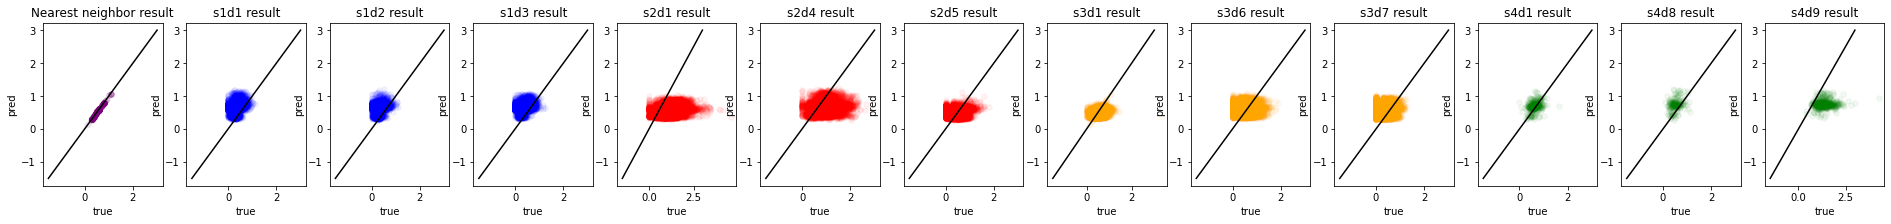

Epoch  10100 near loss: 0.0009921687 s1d1:  0.41373622 s1d2:  0.40038306 s1d3:  0.37402725 s2d1: 0.7989672 s2d4: 0.54159623 s2d5: 0.33453628 s3d1: 0.20645054 s3d6: 0.3455772 s3d7: 0.32923448 s4d1: 0.2121193 s4d8: 0.34455118 s4d9: 0.72475064 test loss: 0.5298096326456446
Epoch  10200 near loss: 0.0015068698 s1d1:  0.4120052 s1d2:  0.3990112 s1d3:  0.37251887 s2d1: 0.7999558 s2d4: 0.5423986 s2d5: 0.33425602 s3d1: 0.20659564 s3d6: 0.34508866 s3d7: 0.3285404 s4d1: 0.2113511 s4d8: 0.3431175 s4d9: 0.72625047 test loss: 0.5304568110008735
Epoch  10300 near loss: 0.00087702146 s1d1:  0.41331744 s1d2:  0.40015513 s1d3:  0.3736252 s2d1: 0.7991512 s2d4: 0.54179716 s2d5: 0.33452746 s3d1: 0.20640798 s3d6: 0.34553894 s3d7: 0.32924026 s4d1: 0.21195318 s4d8: 0.34419227 s4d9: 0.725183 test loss: 0.530010665678555
Epoch  10400 near loss: 0.00072457694 s1d1:  0.41298297 s1d2:  0.39965075 s1d3:  0.37326235 s2d1: 0.7993068 s2d4: 0.5421171 s2d5: 0.33452538 s3d1: 0.20642959 s3d6: 0.34554753 s3d7: 0.32912737 

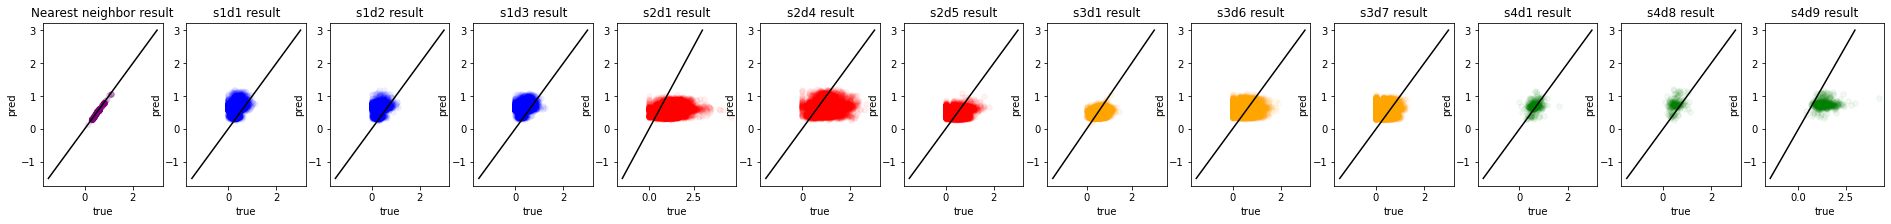

Epoch  11100 near loss: 0.0011829843 s1d1:  0.4101629 s1d2:  0.39611554 s1d3:  0.371105 s2d1: 0.80070883 s2d4: 0.54377 s2d5: 0.33382857 s3d1: 0.20641015 s3d6: 0.3447921 s3d7: 0.32749873 s4d1: 0.21039256 s4d8: 0.3403767 s4d9: 0.7291526 test loss: 0.5317897509420929
Epoch  11200 near loss: 0.0007810067 s1d1:  0.41027975 s1d2:  0.3970146 s1d3:  0.3710347 s2d1: 0.800575 s2d4: 0.5436687 s2d5: 0.33427975 s3d1: 0.20634192 s3d6: 0.3450422 s3d7: 0.32791567 s4d1: 0.21082395 s4d8: 0.34136322 s4d9: 0.728125 test loss: 0.531331217630184
Epoch  11300 near loss: 0.0014275947 s1d1:  0.41198406 s1d2:  0.3985411 s1d3:  0.37269396 s2d1: 0.79949224 s2d4: 0.5428361 s2d5: 0.334609 s3d1: 0.20609766 s3d6: 0.34549302 s3d7: 0.32877642 s4d1: 0.211616 s4d8: 0.34270182 s4d9: 0.72668356 test loss: 0.5307086429396127
Epoch  11400 near loss: 0.0010187088 s1d1:  0.40989998 s1d2:  0.39628264 s1d3:  0.37071443 s2d1: 0.8009399 s2d4: 0.54406536 s2d5: 0.33399418 s3d1: 0.20637265 s3d6: 0.34492755 s3d7: 0.327607 s4d1: 0.2106

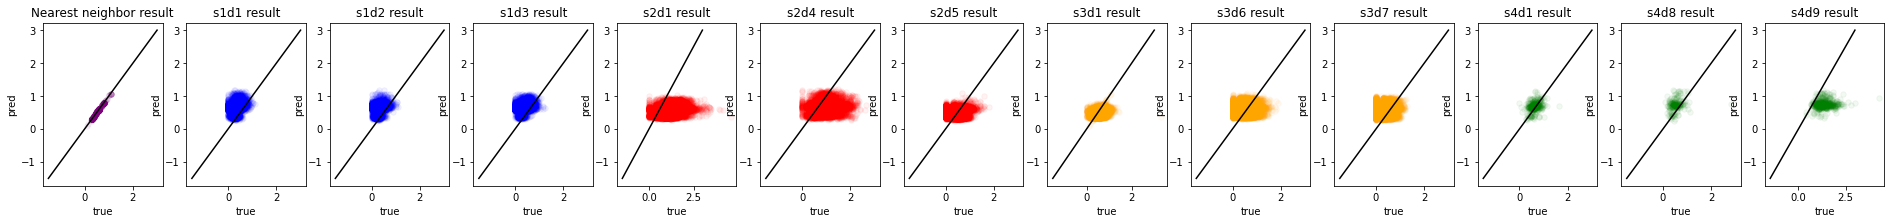

Epoch  12100 near loss: 0.0006458385 s1d1:  0.40874383 s1d2:  0.39501822 s1d3:  0.36997572 s2d1: 0.8011534 s2d4: 0.54471934 s2d5: 0.33413357 s3d1: 0.20626938 s3d6: 0.34486112 s3d7: 0.3271324 s4d1: 0.21030734 s4d8: 0.33962974 s4d9: 0.72991407 test loss: 0.5321589831433199
Epoch  12200 near loss: 0.00075876736 s1d1:  0.4086426 s1d2:  0.39472607 s1d3:  0.3698403 s2d1: 0.8011621 s2d4: 0.5447003 s2d5: 0.3339982 s3d1: 0.20622846 s3d6: 0.34488535 s3d7: 0.32714713 s4d1: 0.21030493 s4d8: 0.33954108 s4d9: 0.730061 test loss: 0.5322394596322069
Epoch  12300 near loss: 0.0016096762 s1d1:  0.40640602 s1d2:  0.39263326 s1d3:  0.36783987 s2d1: 0.8026603 s2d4: 0.5457881 s2d5: 0.33336025 s3d1: 0.20641543 s3d6: 0.34407103 s3d7: 0.32589427 s4d1: 0.20896493 s4d8: 0.33705682 s4d9: 0.73254544 test loss: 0.5333021124666172
Epoch  12400 near loss: 0.00077023596 s1d1:  0.4085247 s1d2:  0.39489827 s1d3:  0.3697423 s2d1: 0.8010242 s2d4: 0.5446361 s2d5: 0.3341005 s3d1: 0.20608652 s3d6: 0.34476995 s3d7: 0.327144 s

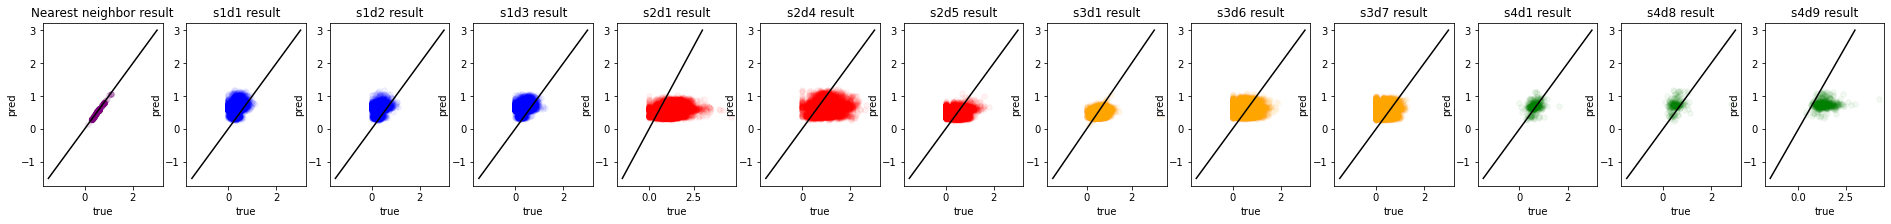

Epoch  13100 near loss: 0.0009014489 s1d1:  0.40720972 s1d2:  0.39365155 s1d3:  0.36867133 s2d1: 0.80175483 s2d4: 0.5456339 s2d5: 0.3340014 s3d1: 0.20606895 s3d6: 0.34462175 s3d7: 0.3265697 s4d1: 0.20965865 s4d8: 0.33821386 s4d9: 0.7316247 test loss: 0.5329644500410222
Epoch  13200 near loss: 0.0005374996 s1d1:  0.4057683 s1d2:  0.39194015 s1d3:  0.36735418 s2d1: 0.8025983 s2d4: 0.5463993 s2d5: 0.33364832 s3d1: 0.20620383 s3d6: 0.3441847 s3d7: 0.3259048 s4d1: 0.20897344 s4d8: 0.3367638 s4d9: 0.7332134 test loss: 0.5336861248540311
Epoch  13300 near loss: 0.00069347967 s1d1:  0.40620014 s1d2:  0.39189184 s1d3:  0.3675472 s2d1: 0.8025938 s2d4: 0.5463629 s2d5: 0.33344707 s3d1: 0.20620084 s3d6: 0.344239 s3d7: 0.32580394 s4d1: 0.20896922 s4d8: 0.33651617 s4d9: 0.7335201 test loss: 0.5338466328779381
Epoch  13400 near loss: 0.0006652397 s1d1:  0.4068612 s1d2:  0.39310881 s1d3:  0.36828634 s2d1: 0.8020287 s2d4: 0.54598653 s2d5: 0.3339558 s3d1: 0.20605056 s3d6: 0.3445238 s3d7: 0.3262922 s4d1: 

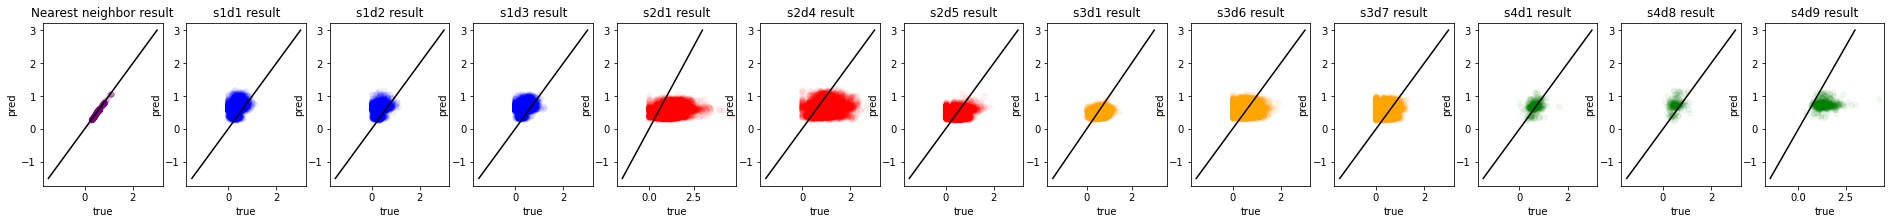

Epoch  14100 near loss: 0.0010527378 s1d1:  0.40587798 s1d2:  0.39165807 s1d3:  0.36759076 s2d1: 0.8023972 s2d4: 0.5466093 s2d5: 0.3338481 s3d1: 0.20602302 s3d6: 0.34446883 s3d7: 0.32582748 s4d1: 0.20933752 s4d8: 0.3367642 s4d9: 0.7330801 test loss: 0.5336497588873929
Epoch  14200 near loss: 0.00062974624 s1d1:  0.40427458 s1d2:  0.39015564 s1d3:  0.36612934 s2d1: 0.8033708 s2d4: 0.54736894 s2d5: 0.33343938 s3d1: 0.2061424 s3d6: 0.3439468 s3d7: 0.3250728 s4d1: 0.2084947 s4d8: 0.33520544 s4d9: 0.73470974 test loss: 0.5343645978007182
Epoch  14300 near loss: 0.00060872815 s1d1:  0.40426755 s1d2:  0.3902058 s1d3:  0.36612454 s2d1: 0.8031897 s2d4: 0.5474026 s2d5: 0.3335595 s3d1: 0.20609197 s3d6: 0.3440553 s3d7: 0.3251639 s4d1: 0.20861976 s4d8: 0.3353436 s4d9: 0.7345417 test loss: 0.534292835686636
Epoch  14400 near loss: 0.0010485478 s1d1:  0.40366548 s1d2:  0.38930607 s1d3:  0.36549926 s2d1: 0.80374527 s2d4: 0.5478786 s2d5: 0.33322617 s3d1: 0.20620723 s3d6: 0.3437422 s3d7: 0.3246199 s4d1:

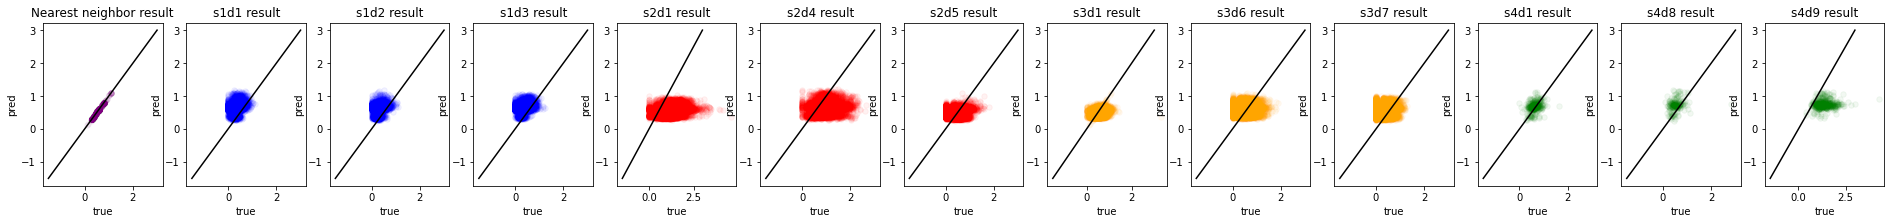

Epoch  15100 near loss: 0.0007461638 s1d1:  0.40266374 s1d2:  0.38805515 s1d3:  0.36474043 s2d1: 0.8039776 s2d4: 0.5484525 s2d5: 0.33317322 s3d1: 0.20611252 s3d6: 0.34372023 s3d7: 0.32423404 s4d1: 0.2077281 s4d8: 0.33317366 s4d9: 0.73687875 test loss: 0.5353717637451896
Epoch  15200 near loss: 0.001322468 s1d1:  0.4024763 s1d2:  0.38763338 s1d3:  0.36440447 s2d1: 0.8044139 s2d4: 0.54852635 s2d5: 0.3328856 s3d1: 0.2061171 s3d6: 0.34351486 s3d7: 0.3240667 s4d1: 0.20751384 s4d8: 0.3328574 s4d9: 0.7373755 test loss: 0.5356171784280546
Epoch  15300 near loss: 0.0008326052 s1d1:  0.40286428 s1d2:  0.3885182 s1d3:  0.36503413 s2d1: 0.80396295 s2d4: 0.5481566 s2d5: 0.33324698 s3d1: 0.20597072 s3d6: 0.34362707 s3d7: 0.32436886 s4d1: 0.20773573 s4d8: 0.33334503 s4d9: 0.7364022 test loss: 0.5350938221306449
Epoch  15400 near loss: 0.0012063524 s1d1:  0.40152398 s1d2:  0.38753337 s1d3:  0.36381337 s2d1: 0.80511844 s2d4: 0.5490673 s2d5: 0.33293724 s3d1: 0.20625731 s3d6: 0.3433061 s3d7: 0.32368284 s

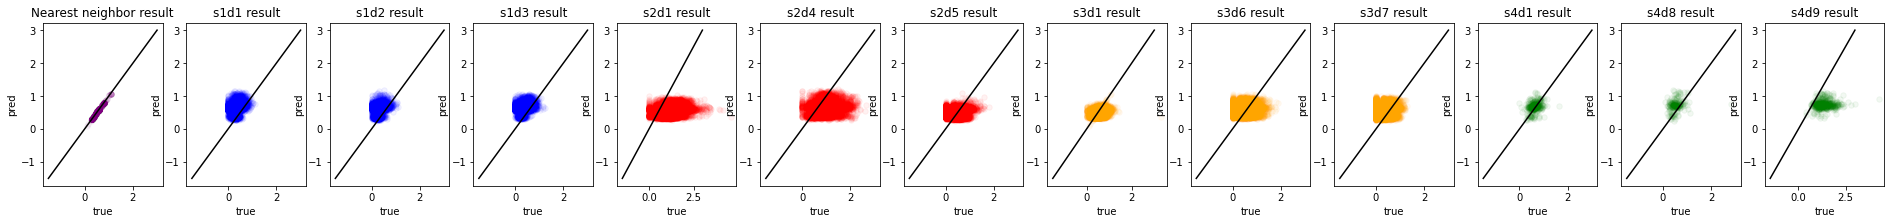

Epoch  16100 near loss: 0.0011922733 s1d1:  0.40094873 s1d2:  0.3865545 s1d3:  0.3632393 s2d1: 0.8050169 s2d4: 0.5492079 s2d5: 0.3328397 s3d1: 0.20609368 s3d6: 0.34318432 s3d7: 0.32352856 s4d1: 0.20714132 s4d8: 0.33173406 s4d9: 0.73851395 test loss: 0.5361444222143441
Epoch  16200 near loss: 0.00080036576 s1d1:  0.40175518 s1d2:  0.38747913 s1d3:  0.36411998 s2d1: 0.8046894 s2d4: 0.5489512 s2d5: 0.33316588 s3d1: 0.20606671 s3d6: 0.34344643 s3d7: 0.32383063 s4d1: 0.20755127 s4d8: 0.3325199 s4d9: 0.7378095 test loss: 0.5358528913991925
Epoch  16300 near loss: 0.00087998144 s1d1:  0.40130574 s1d2:  0.38728312 s1d3:  0.36369538 s2d1: 0.8048368 s2d4: 0.5492257 s2d5: 0.33318463 s3d1: 0.20609252 s3d6: 0.3434493 s3d7: 0.3237813 s4d1: 0.20748138 s4d8: 0.332491 s4d9: 0.738009 test loss: 0.5359662128631094
Epoch  16400 near loss: 0.00084474246 s1d1:  0.40201357 s1d2:  0.387822 s1d3:  0.36446393 s2d1: 0.8044512 s2d4: 0.54885846 s2d5: 0.33328345 s3d1: 0.205957 s3d6: 0.3434914 s3d7: 0.3240315 s4d1: 

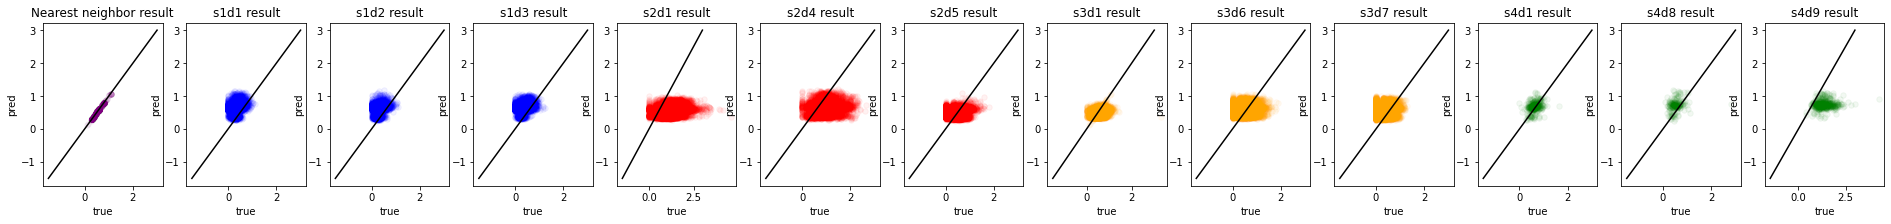

Epoch  17100 near loss: 0.0011120836 s1d1:  0.3998783 s1d2:  0.38547087 s1d3:  0.36234573 s2d1: 0.80548894 s2d4: 0.5500824 s2d5: 0.33282253 s3d1: 0.20603114 s3d6: 0.34307268 s3d7: 0.32299197 s4d1: 0.20668723 s4d8: 0.33071145 s4d9: 0.7396487 test loss: 0.5366728744724099
Epoch  17200 near loss: 0.0013973879 s1d1:  0.40188473 s1d2:  0.38750464 s1d3:  0.36423254 s2d1: 0.8041352 s2d4: 0.5491273 s2d5: 0.33347288 s3d1: 0.20577832 s3d6: 0.34374723 s3d7: 0.32405308 s4d1: 0.20774971 s4d8: 0.33260676 s4d9: 0.73750687 test loss: 0.5356985090489964
Epoch  17300 near loss: 0.001518461 s1d1:  0.39942992 s1d2:  0.384694 s1d3:  0.36200884 s2d1: 0.805651 s2d4: 0.5501842 s2d5: 0.33255398 s3d1: 0.20599474 s3d6: 0.34282744 s3d7: 0.32270402 s4d1: 0.20637238 s4d8: 0.32979804 s4d9: 0.7404301 test loss: 0.5370105358526283
Epoch  17400 near loss: 0.00088341034 s1d1:  0.40031865 s1d2:  0.38575727 s1d3:  0.36291453 s2d1: 0.80501884 s2d4: 0.549681 s2d5: 0.33282784 s3d1: 0.20585807 s3d6: 0.3431758 s3d7: 0.3233121 

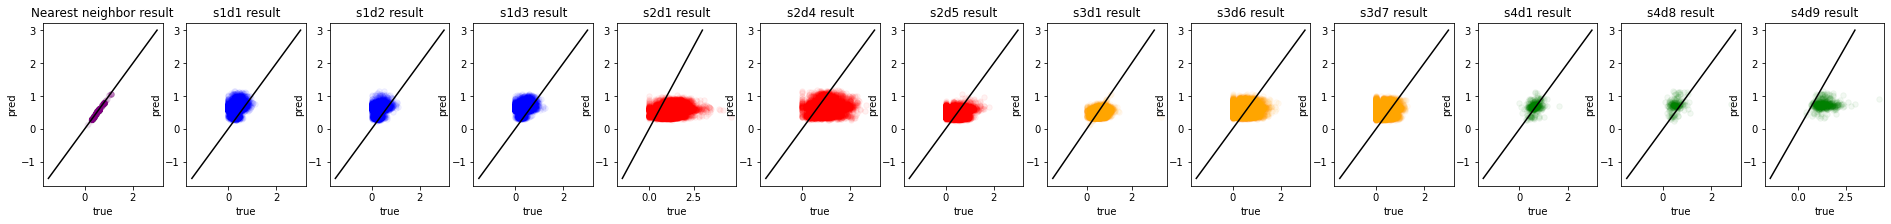

Epoch  18100 near loss: 0.0007396266 s1d1:  0.400041 s1d2:  0.3860114 s1d3:  0.36275703 s2d1: 0.805182 s2d4: 0.55003834 s2d5: 0.3332477 s3d1: 0.20586422 s3d6: 0.3433222 s3d7: 0.32331428 s4d1: 0.20705403 s4d8: 0.33084932 s4d9: 0.7394352 test loss: 0.5366026434880893
Epoch  18200 near loss: 0.0006294238 s1d1:  0.39903754 s1d2:  0.38477802 s1d3:  0.36177486 s2d1: 0.80605817 s2d4: 0.5507058 s2d5: 0.3328064 s3d1: 0.20604928 s3d6: 0.34293768 s3d7: 0.32260874 s4d1: 0.20651022 s4d8: 0.3297993 s4d9: 0.7408907 test loss: 0.5373198671945743
Epoch  18300 near loss: 0.00092152605 s1d1:  0.4004859 s1d2:  0.38635093 s1d3:  0.36321878 s2d1: 0.80499685 s2d4: 0.5499352 s2d5: 0.33340687 s3d1: 0.20583591 s3d6: 0.343447 s3d7: 0.3233935 s4d1: 0.20729053 s4d8: 0.33112887 s4d9: 0.73910177 test loss: 0.5364579668151813
Epoch  18400 near loss: 0.0012067361 s1d1:  0.40025446 s1d2:  0.385974 s1d3:  0.3630063 s2d1: 0.80500394 s2d4: 0.5500552 s2d5: 0.33337313 s3d1: 0.20580126 s3d6: 0.3434693 s3d7: 0.32337612 s4d1: 

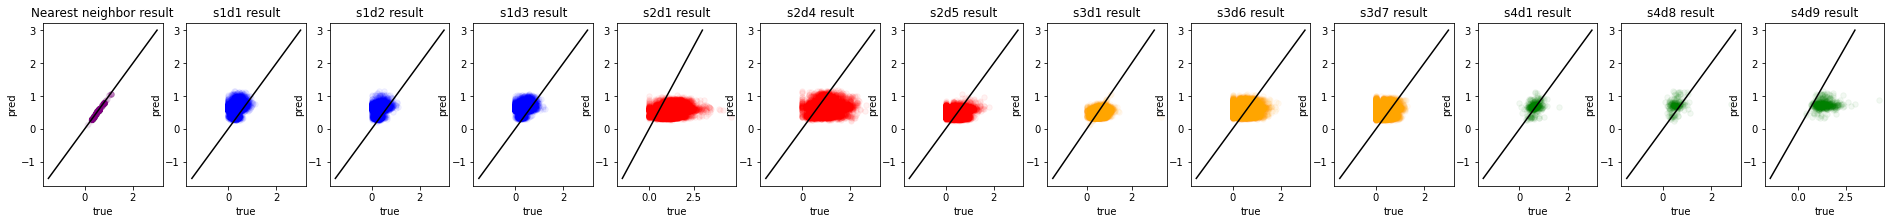

Epoch  19100 near loss: 0.00089921267 s1d1:  0.39981902 s1d2:  0.3854381 s1d3:  0.36257368 s2d1: 0.80550414 s2d4: 0.5504638 s2d5: 0.3332569 s3d1: 0.20583245 s3d6: 0.343273 s3d7: 0.3230543 s4d1: 0.20693654 s4d8: 0.3303275 s4d9: 0.7401547 test loss: 0.5369761229693055
Epoch  19200 near loss: 0.00061283825 s1d1:  0.3988742 s1d2:  0.38456348 s1d3:  0.36176994 s2d1: 0.80581164 s2d4: 0.5506606 s2d5: 0.33294377 s3d1: 0.20580368 s3d6: 0.3429502 s3d7: 0.32276255 s4d1: 0.20640835 s4d8: 0.32953963 s4d9: 0.74103844 test loss: 0.5373673219064043
Epoch  19300 near loss: 0.0007425223 s1d1:  0.3990379 s1d2:  0.38466188 s1d3:  0.36193377 s2d1: 0.80578405 s2d4: 0.55062586 s2d5: 0.33304113 s3d1: 0.20579705 s3d6: 0.34308875 s3d7: 0.32282993 s4d1: 0.20659325 s4d8: 0.3297116 s4d9: 0.74095774 test loss: 0.5373618233509507
Epoch  19400 near loss: 0.001038587 s1d1:  0.39755234 s1d2:  0.38318285 s1d3:  0.3606716 s2d1: 0.80672413 s2d4: 0.55135864 s2d5: 0.33264434 s3d1: 0.20595323 s3d6: 0.34263137 s3d7: 0.3220346

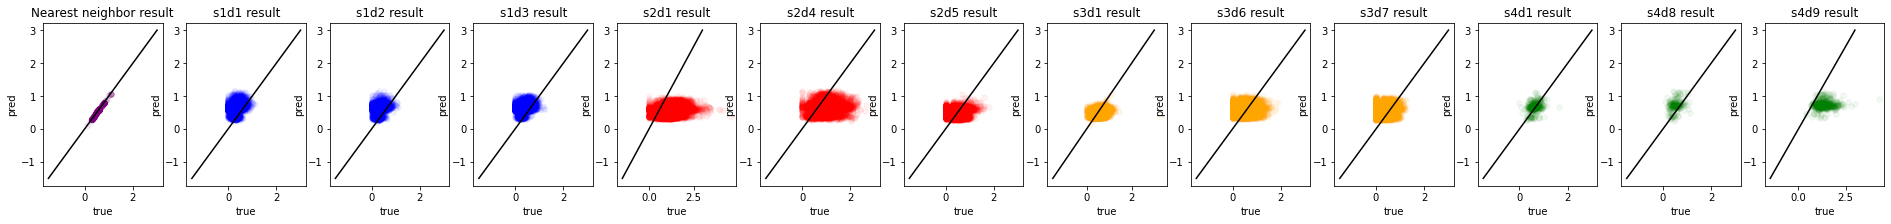

Epoch  20100 near loss: 0.00051177206 s1d1:  0.39820686 s1d2:  0.3837767 s1d3:  0.3612845 s2d1: 0.8062112 s2d4: 0.55129355 s2d5: 0.33299553 s3d1: 0.20585996 s3d6: 0.3429749 s3d7: 0.3223968 s4d1: 0.20652917 s4d8: 0.3291469 s4d9: 0.74157673 test loss: 0.5376737716591798
Epoch  20200 near loss: 0.00060267147 s1d1:  0.3982921 s1d2:  0.38372 s1d3:  0.36137113 s2d1: 0.8063353 s2d4: 0.5514045 s2d5: 0.3329701 s3d1: 0.205898 s3d6: 0.34294704 s3d7: 0.32214448 s4d1: 0.20640618 s4d8: 0.3287479 s4d9: 0.7418065 test loss: 0.5377529365182492
Epoch  20300 near loss: 0.0007719373 s1d1:  0.39821857 s1d2:  0.38351482 s1d3:  0.36118606 s2d1: 0.80617076 s2d4: 0.55127156 s2d5: 0.33281046 s3d1: 0.20582774 s3d6: 0.34298488 s3d7: 0.3224033 s4d1: 0.20643185 s4d8: 0.32907218 s4d9: 0.74200696 test loss: 0.5379241920834813
Epoch  20400 near loss: 0.00055025134 s1d1:  0.39741898 s1d2:  0.38304672 s1d3:  0.36071303 s2d1: 0.8066364 s2d4: 0.5517241 s2d5: 0.33283758 s3d1: 0.2058846 s3d6: 0.34275395 s3d7: 0.32203665 s4d

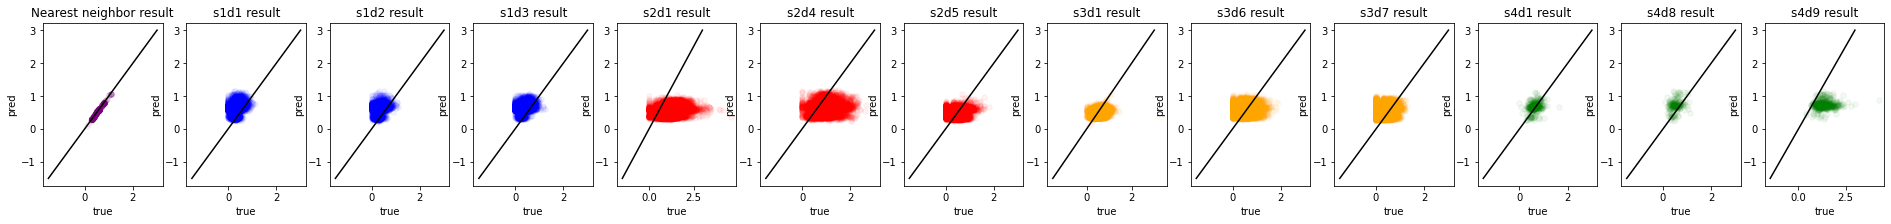

Epoch  21100 near loss: 0.0008734021 s1d1:  0.3975499 s1d2:  0.38329262 s1d3:  0.36079845 s2d1: 0.80605936 s2d4: 0.5513798 s2d5: 0.3330492 s3d1: 0.20560704 s3d6: 0.34278956 s3d7: 0.3222798 s4d1: 0.20610304 s4d8: 0.32815894 s4d9: 0.74226886 test loss: 0.5379324502689096
Epoch  21200 near loss: 0.0009551261 s1d1:  0.39623618 s1d2:  0.38197145 s1d3:  0.35949752 s2d1: 0.8071628 s2d4: 0.55232316 s2d5: 0.33263266 s3d1: 0.20584595 s3d6: 0.342496 s3d7: 0.32161617 s4d1: 0.2055925 s4d8: 0.32721433 s4d9: 0.74380565 test loss: 0.5387218567023248
Epoch  21300 near loss: 0.00082999707 s1d1:  0.3959058 s1d2:  0.38151318 s1d3:  0.35926735 s2d1: 0.80718285 s2d4: 0.5523847 s2d5: 0.3326756 s3d1: 0.20581493 s3d6: 0.3424357 s3d7: 0.32147938 s4d1: 0.20560887 s4d8: 0.32699162 s4d9: 0.7438387 test loss: 0.5387169005502584
Epoch  21400 near loss: 0.0007880924 s1d1:  0.3959384 s1d2:  0.3815298 s1d3:  0.3593504 s2d1: 0.80714613 s2d4: 0.552388 s2d5: 0.33268115 s3d1: 0.2058197 s3d6: 0.3425021 s3d7: 0.32150236 s4d1

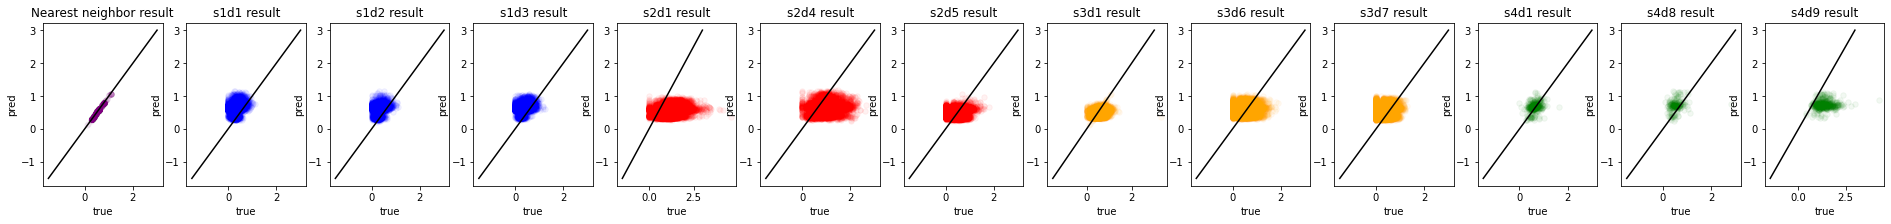

Epoch  22100 near loss: 0.0008166884 s1d1:  0.3958694 s1d2:  0.38162702 s1d3:  0.3592783 s2d1: 0.80721235 s2d4: 0.552441 s2d5: 0.33266503 s3d1: 0.20575742 s3d6: 0.34243166 s3d7: 0.32150117 s4d1: 0.20553285 s4d8: 0.32685658 s4d9: 0.7440656 test loss: 0.5388340316173279
Epoch  22200 near loss: 0.0011099989 s1d1:  0.39723343 s1d2:  0.38274848 s1d3:  0.3606419 s2d1: 0.80629826 s2d4: 0.5518623 s2d5: 0.33310804 s3d1: 0.20562048 s3d6: 0.34289044 s3d7: 0.32208467 s4d1: 0.20622648 s4d8: 0.32790145 s4d9: 0.74267936 test loss: 0.5381757603357135
Epoch  22300 near loss: 0.00078457716 s1d1:  0.39661944 s1d2:  0.38197154 s1d3:  0.36008322 s2d1: 0.80667675 s2d4: 0.5521523 s2d5: 0.33289292 s3d1: 0.20566528 s3d6: 0.34268484 s3d7: 0.32178107 s4d1: 0.2059996 s4d8: 0.327376 s4d9: 0.74335253 test loss: 0.538507006693979
Epoch  22400 near loss: 0.0023316466 s1d1:  0.39344564 s1d2:  0.37891525 s1d3:  0.3571647 s2d1: 0.80892813 s2d4: 0.55401117 s2d5: 0.33203906 s3d1: 0.20611857 s3d6: 0.34181553 s3d7: 0.320094

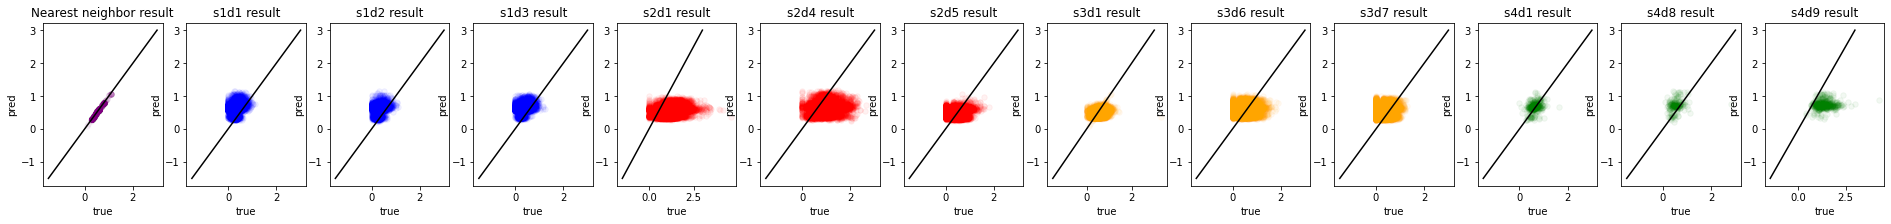

Epoch  23100 near loss: 0.0010489722 s1d1:  0.39697567 s1d2:  0.38261473 s1d3:  0.3603535 s2d1: 0.8066054 s2d4: 0.5520756 s2d5: 0.33309898 s3d1: 0.20559381 s3d6: 0.3427939 s3d7: 0.32193923 s4d1: 0.20609309 s4d8: 0.32747692 s4d9: 0.74298745 test loss: 0.5383003777578269
Epoch  23200 near loss: 0.0005548771 s1d1:  0.3959195 s1d2:  0.3813039 s1d3:  0.35947144 s2d1: 0.80729634 s2d4: 0.55279803 s2d5: 0.3328103 s3d1: 0.20578574 s3d6: 0.34259552 s3d7: 0.32139894 s4d1: 0.20578213 s4d8: 0.32671875 s4d9: 0.7442471 test loss: 0.5389635426594933
Epoch  23300 near loss: 0.001473111 s1d1:  0.39387813 s1d2:  0.3792688 s1d3:  0.35745722 s2d1: 0.808513 s2d4: 0.55381244 s2d5: 0.3322579 s3d1: 0.20597999 s3d6: 0.34203506 s3d7: 0.32045653 s4d1: 0.20497602 s4d8: 0.32514954 s4d9: 0.7462101 test loss: 0.5399095403203158
Epoch  23400 near loss: 0.0008057379 s1d1:  0.39639515 s1d2:  0.3817385 s1d3:  0.35988596 s2d1: 0.8067324 s2d4: 0.55230474 s2d5: 0.33297494 s3d1: 0.20561111 s3d6: 0.34268376 s3d7: 0.32167706 s

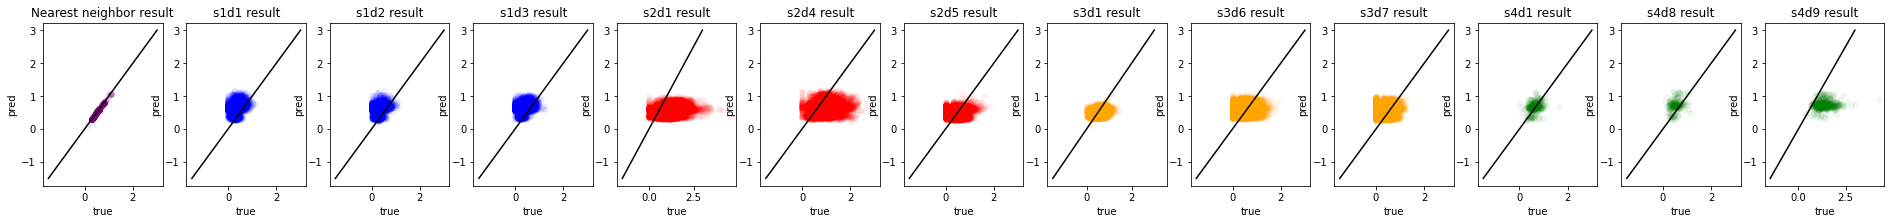

Epoch  24100 near loss: 0.00080563064 s1d1:  0.39423114 s1d2:  0.3796103 s1d3:  0.35799724 s2d1: 0.8079993 s2d4: 0.5533676 s2d5: 0.3324105 s3d1: 0.20579961 s3d6: 0.34213242 s3d7: 0.3207552 s4d1: 0.20510821 s4d8: 0.32529634 s4d9: 0.7457639 test loss: 0.539661577142772
Epoch  24200 near loss: 0.00060930726 s1d1:  0.39536163 s1d2:  0.38054255 s1d3:  0.35893843 s2d1: 0.8073023 s2d4: 0.552827 s2d5: 0.33261812 s3d1: 0.20564097 s3d6: 0.34242457 s3d7: 0.32128385 s4d1: 0.20543419 s4d8: 0.3260692 s4d9: 0.7447166 test loss: 0.539135446940941
Epoch  24300 near loss: 0.0007822028 s1d1:  0.3943394 s1d2:  0.37993503 s1d3:  0.35808876 s2d1: 0.8080824 s2d4: 0.5534063 s2d5: 0.33249813 s3d1: 0.20582248 s3d6: 0.34223792 s3d7: 0.32084587 s4d1: 0.20519812 s4d8: 0.3255978 s4d9: 0.7455779 test loss: 0.5395926507092602
Epoch  24400 near loss: 0.0007229141 s1d1:  0.39466596 s1d2:  0.38011485 s1d3:  0.35844025 s2d1: 0.8077973 s2d4: 0.55322486 s2d5: 0.33263618 s3d1: 0.20570482 s3d6: 0.34219727 s3d7: 0.32085046 s4

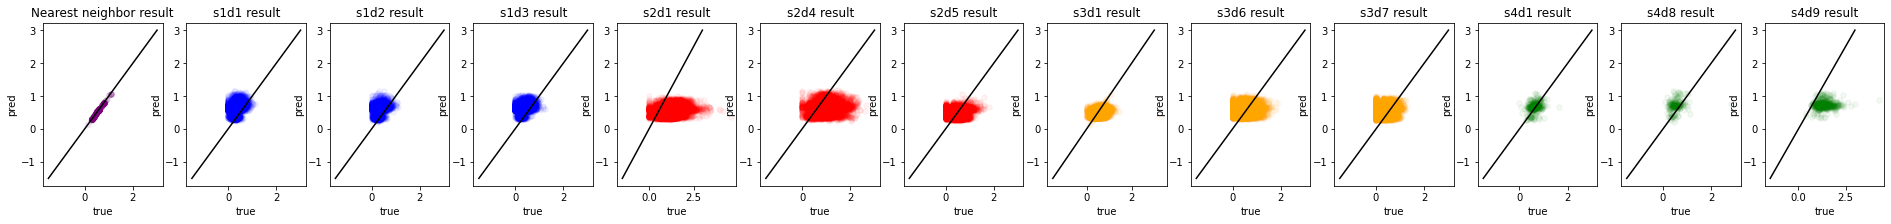

Epoch  25100 near loss: 0.0011029673 s1d1:  0.3936292 s1d2:  0.37914166 s1d3:  0.35744992 s2d1: 0.8085833 s2d4: 0.5539974 s2d5: 0.33240783 s3d1: 0.20589262 s3d6: 0.3420662 s3d7: 0.32032552 s4d1: 0.2049622 s4d8: 0.32462782 s4d9: 0.74645233 test loss: 0.5399964840540512
Epoch  25200 near loss: 0.0010594422 s1d1:  0.3939081 s1d2:  0.3792186 s1d3:  0.3577328 s2d1: 0.8082242 s2d4: 0.55363905 s2d5: 0.3323516 s3d1: 0.20575826 s3d6: 0.34198394 s3d7: 0.32045832 s4d1: 0.20474383 s4d8: 0.32440034 s4d9: 0.74647033 test loss: 0.5399519404796191
Epoch  25300 near loss: 0.0007961921 s1d1:  0.39468446 s1d2:  0.38047063 s1d3:  0.35844123 s2d1: 0.80765224 s2d4: 0.5530655 s2d5: 0.33271933 s3d1: 0.2056158 s3d6: 0.34226802 s3d7: 0.3211106 s4d1: 0.20527257 s4d8: 0.32571357 s4d9: 0.74513924 test loss: 0.5393383855426382
Epoch  25400 near loss: 0.0005898447 s1d1:  0.39492998 s1d2:  0.380455 s1d3:  0.35871905 s2d1: 0.8076213 s2d4: 0.55320144 s2d5: 0.3328153 s3d1: 0.20567909 s3d6: 0.3424487 s3d7: 0.32104468 s4d

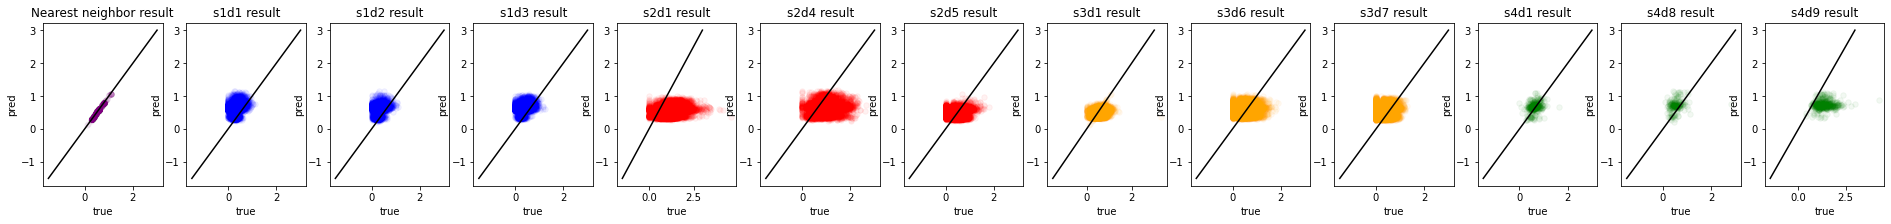

Epoch  26100 near loss: 0.0010452884 s1d1:  0.39330938 s1d2:  0.37888113 s1d3:  0.3572328 s2d1: 0.8085776 s2d4: 0.55396867 s2d5: 0.33241242 s3d1: 0.20577835 s3d6: 0.3419789 s3d7: 0.32040873 s4d1: 0.20491816 s4d8: 0.32472286 s4d9: 0.74660635 test loss: 0.5401004520035309
Epoch  26200 near loss: 0.0006035441 s1d1:  0.39419523 s1d2:  0.3795752 s1d3:  0.357944 s2d1: 0.8080397 s2d4: 0.55354226 s2d5: 0.3325494 s3d1: 0.20566371 s3d6: 0.3422121 s3d7: 0.32080445 s4d1: 0.20520005 s4d8: 0.32520676 s4d9: 0.7458951 test loss: 0.5397452712393537
Epoch  26300 near loss: 0.0005652605 s1d1:  0.39396036 s1d2:  0.37923583 s1d3:  0.35776022 s2d1: 0.8082536 s2d4: 0.5538442 s2d5: 0.3325671 s3d1: 0.20575836 s3d6: 0.34222075 s3d7: 0.3206652 s4d1: 0.20530662 s4d8: 0.32505712 s4d9: 0.7461389 test loss: 0.5398948009466253
Epoch  26400 near loss: 0.0011166005 s1d1:  0.3927768 s1d2:  0.3779637 s1d3:  0.3567068 s2d1: 0.80911195 s2d4: 0.5546454 s2d5: 0.3322068 s3d1: 0.2059657 s3d6: 0.34190905 s3d7: 0.31992033 s4d1: 

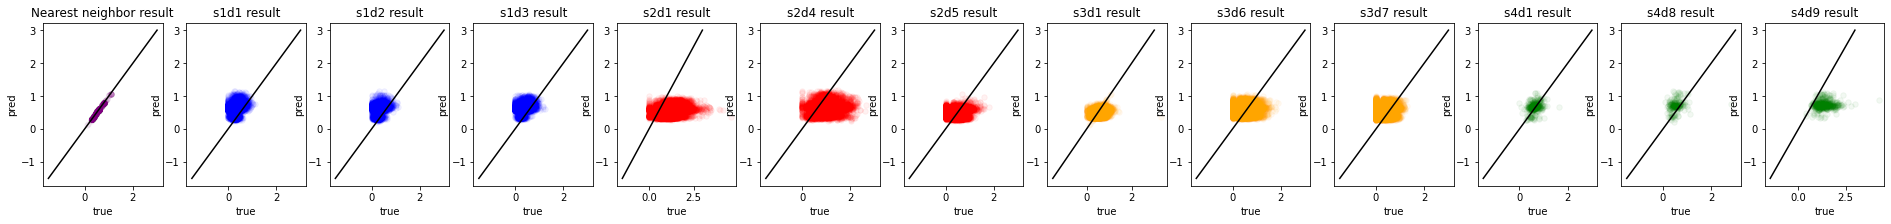

Epoch  27100 near loss: 0.00073552574 s1d1:  0.39432022 s1d2:  0.380012 s1d3:  0.3581912 s2d1: 0.8079356 s2d4: 0.5535756 s2d5: 0.33278677 s3d1: 0.20563956 s3d6: 0.34237093 s3d7: 0.3209269 s4d1: 0.20550574 s4d8: 0.32547456 s4d9: 0.7454694 test loss: 0.5395475570582378
Epoch  27200 near loss: 0.0007443801 s1d1:  0.3929949 s1d2:  0.37861925 s1d3:  0.35703567 s2d1: 0.80881697 s2d4: 0.5543689 s2d5: 0.332493 s3d1: 0.20580299 s3d6: 0.3420062 s3d7: 0.32017723 s4d1: 0.20500295 s4d8: 0.32437995 s4d9: 0.7469019 test loss: 0.5402561225430548
Epoch  27300 near loss: 0.00092153274 s1d1:  0.39317936 s1d2:  0.37874395 s1d3:  0.35710752 s2d1: 0.808738 s2d4: 0.5543126 s2d5: 0.33245736 s3d1: 0.2057817 s3d6: 0.34203234 s3d7: 0.32021558 s4d1: 0.2049409 s4d8: 0.32428432 s4d9: 0.74697006 test loss: 0.540279596412366
Epoch  27400 near loss: 0.0005675495 s1d1:  0.39371803 s1d2:  0.37915313 s1d3:  0.35765642 s2d1: 0.8082664 s2d4: 0.55401534 s2d5: 0.3325795 s3d1: 0.20571332 s3d6: 0.34216538 s3d7: 0.32042632 s4d1

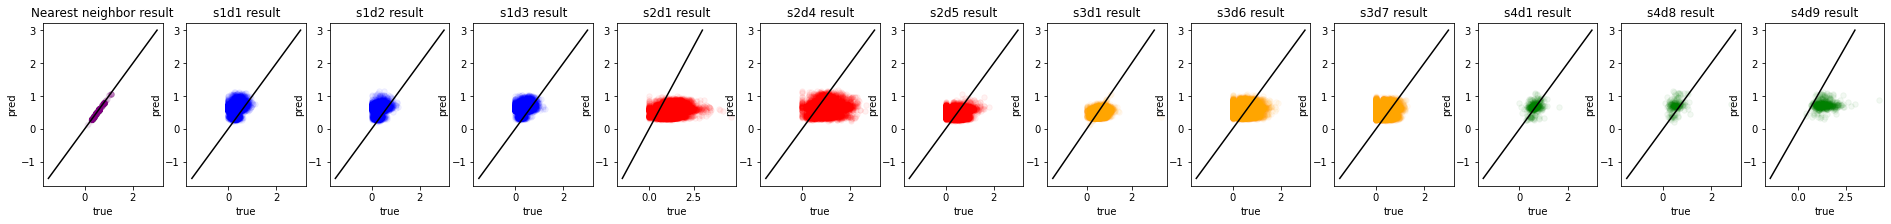

Epoch  28100 near loss: 0.0006075241 s1d1:  0.39280158 s1d2:  0.37833214 s1d3:  0.35690358 s2d1: 0.80873597 s2d4: 0.55458707 s2d5: 0.33252257 s3d1: 0.2057712 s3d6: 0.34201932 s3d7: 0.32012278 s4d1: 0.20487474 s4d8: 0.32415292 s4d9: 0.7473187 test loss: 0.5404761434081341
Epoch  28200 near loss: 0.0013248797 s1d1:  0.39421228 s1d2:  0.37969172 s1d3:  0.35831708 s2d1: 0.8075965 s2d4: 0.5537407 s2d5: 0.33301347 s3d1: 0.205526 s3d6: 0.3424294 s3d7: 0.32095963 s4d1: 0.20552771 s4d8: 0.32530576 s4d9: 0.745758 test loss: 0.539712304613531
Epoch  28300 near loss: 0.000441099 s1d1:  0.39326414 s1d2:  0.37887096 s1d3:  0.35736638 s2d1: 0.80841637 s2d4: 0.5541874 s2d5: 0.33265367 s3d1: 0.20566508 s3d6: 0.3421062 s3d7: 0.32040235 s4d1: 0.20505354 s4d8: 0.3243793 s4d9: 0.7467524 test loss: 0.5401675464382987
Epoch  28400 near loss: 0.0018172446 s1d1:  0.39153722 s1d2:  0.37675563 s1d3:  0.3556621 s2d1: 0.8097029 s2d4: 0.55514646 s2d5: 0.33190405 s3d1: 0.20590751 s3d6: 0.3415229 s3d7: 0.31936705 s4d

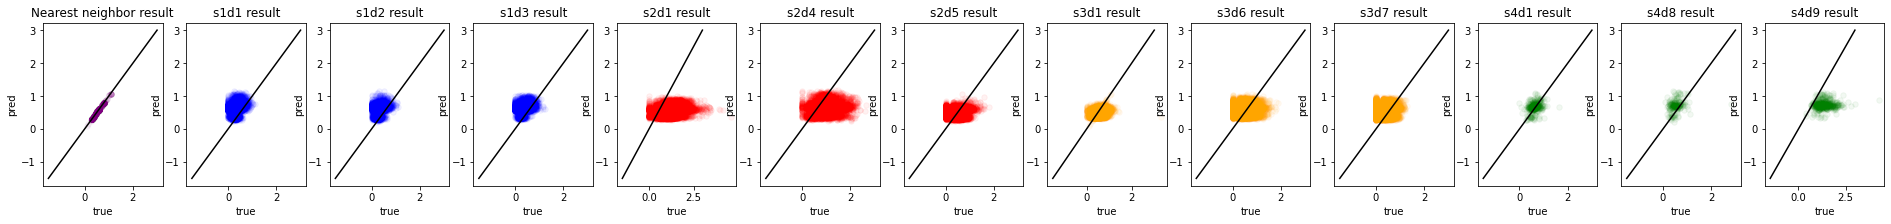

Epoch  29100 near loss: 0.0012694952 s1d1:  0.39420575 s1d2:  0.38009912 s1d3:  0.3583038 s2d1: 0.8075518 s2d4: 0.55345595 s2d5: 0.33301067 s3d1: 0.20539552 s3d6: 0.34238312 s3d7: 0.3211072 s4d1: 0.20544662 s4d8: 0.32538277 s4d9: 0.7454246 test loss: 0.539500178523118
Epoch  29200 near loss: 0.00057394366 s1d1:  0.39259508 s1d2:  0.37823492 s1d3:  0.35678044 s2d1: 0.8090092 s2d4: 0.5546432 s2d5: 0.3325248 s3d1: 0.20577464 s3d6: 0.34201783 s3d7: 0.32009375 s4d1: 0.20493504 s4d8: 0.32417187 s4d9: 0.74739254 test loss: 0.5405330028151547
Epoch  29300 near loss: 0.000430167 s1d1:  0.3933446 s1d2:  0.37894735 s1d3:  0.3575129 s2d1: 0.808387 s2d4: 0.5542667 s2d5: 0.33276135 s3d1: 0.20565905 s3d6: 0.3422138 s3d7: 0.3204325 s4d1: 0.20516434 s4d8: 0.3243728 s4d9: 0.7466938 test loss: 0.5401436154179223
Epoch  29400 near loss: 0.00094845425 s1d1:  0.3933446 s1d2:  0.37881598 s1d3:  0.35747385 s2d1: 0.8080173 s2d4: 0.5540445 s2d5: 0.33273858 s3d1: 0.20552176 s3d6: 0.34221813 s3d7: 0.32065228 s4d1

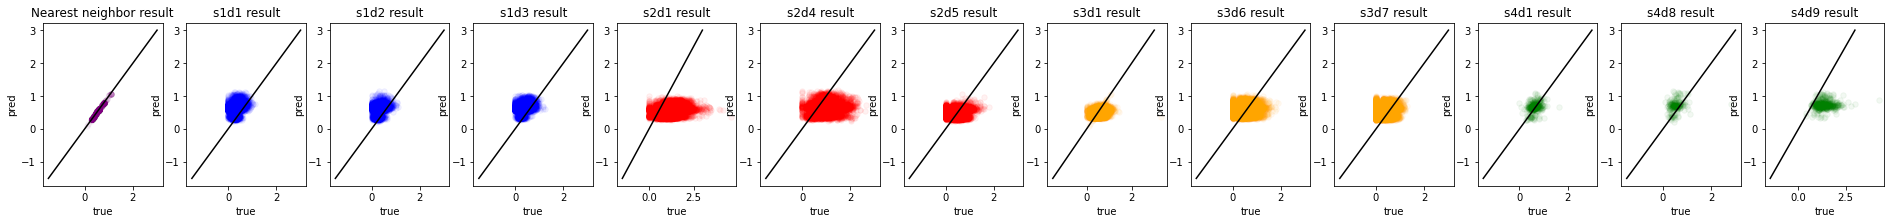

Epoch  30100 near loss: 0.0010367024 s1d1:  0.39253154 s1d2:  0.37760714 s1d3:  0.35668802 s2d1: 0.8088299 s2d4: 0.55458486 s2d5: 0.33225098 s3d1: 0.2056654 s3d6: 0.34185618 s3d7: 0.31994972 s4d1: 0.20460215 s4d8: 0.3232515 s4d9: 0.7479322 test loss: 0.5407193853490527
Epoch  30200 near loss: 0.001107698 s1d1:  0.39402127 s1d2:  0.37928984 s1d3:  0.35806805 s2d1: 0.8076136 s2d4: 0.55379784 s2d5: 0.3328924 s3d1: 0.20543543 s3d6: 0.34238955 s3d7: 0.32083237 s4d1: 0.2054102 s4d8: 0.32495183 s4d9: 0.7460127 test loss: 0.5398147946223163
Epoch  30300 near loss: 0.0006087722 s1d1:  0.39289525 s1d2:  0.3780488 s1d3:  0.3570434 s2d1: 0.8085884 s2d4: 0.55466056 s2d5: 0.33258566 s3d1: 0.20565937 s3d6: 0.3420702 s3d7: 0.3201003 s4d1: 0.20498197 s4d8: 0.32370707 s4d9: 0.74741346 test loss: 0.5404945714056095
Epoch  30400 near loss: 0.0010062925 s1d1:  0.39306486 s1d2:  0.37866306 s1d3:  0.3572033 s2d1: 0.80822855 s2d4: 0.5541787 s2d5: 0.3326522 s3d1: 0.2055131 s3d6: 0.3420656 s3d7: 0.32045463 s4d1

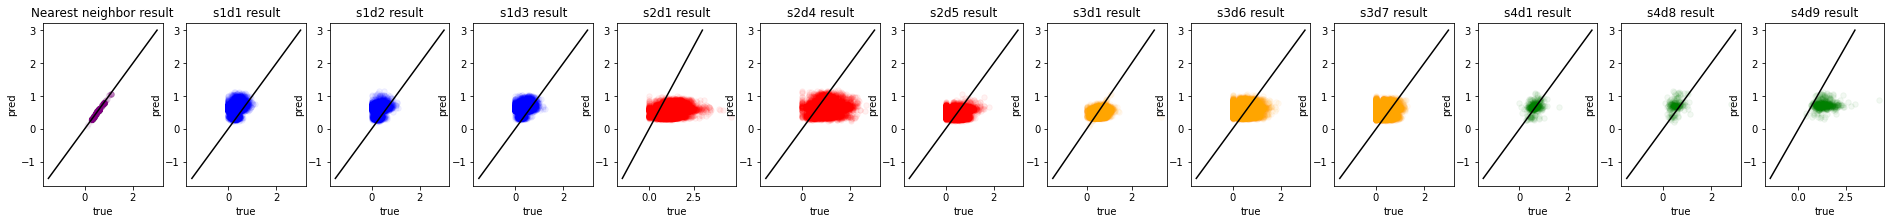

Epoch  31100 near loss: 0.00092819135 s1d1:  0.39218876 s1d2:  0.37774011 s1d3:  0.35631227 s2d1: 0.8090222 s2d4: 0.5547751 s2d5: 0.3323516 s3d1: 0.20566519 s3d6: 0.34176266 s3d7: 0.31989387 s4d1: 0.20463271 s4d8: 0.32329497 s4d9: 0.74793637 test loss: 0.5407312594089847
Epoch  31200 near loss: 0.0005777076 s1d1:  0.391971 s1d2:  0.37716907 s1d3:  0.35615143 s2d1: 0.8089903 s2d4: 0.55491704 s2d5: 0.33223867 s3d1: 0.20567062 s3d6: 0.34174997 s3d7: 0.31982297 s4d1: 0.20454118 s4d8: 0.3229562 s4d9: 0.74837965 test loss: 0.5409592778371703
Epoch  31300 near loss: 0.0007637685 s1d1:  0.3921455 s1d2:  0.37775153 s1d3:  0.35632566 s2d1: 0.8087484 s2d4: 0.55457455 s2d5: 0.33239877 s3d1: 0.20553106 s3d6: 0.341721 s3d7: 0.32010767 s4d1: 0.20457146 s4d8: 0.3233353 s4d9: 0.7478419 test loss: 0.5406685496578763
Epoch  31400 near loss: 0.0009645414 s1d1:  0.39163545 s1d2:  0.37686804 s1d3:  0.3558554 s2d1: 0.80936545 s2d4: 0.5552134 s2d5: 0.33218536 s3d1: 0.20571749 s3d6: 0.34162652 s3d7: 0.31959945

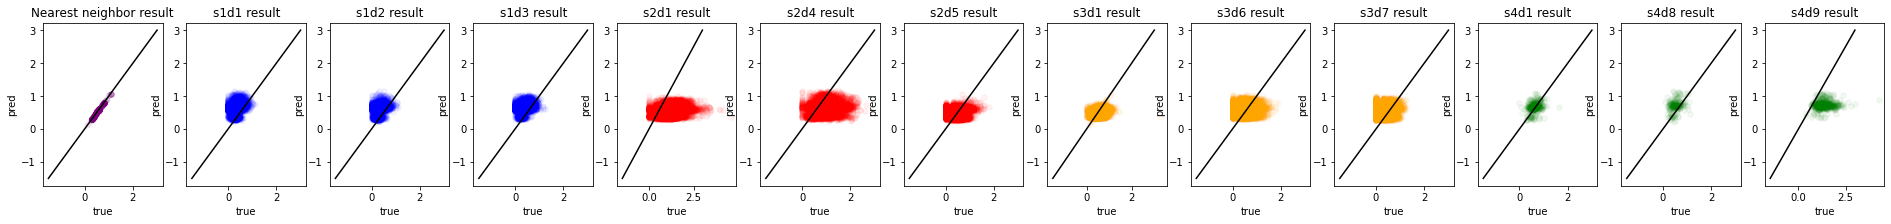

Epoch  32100 near loss: 0.00064883614 s1d1:  0.39187807 s1d2:  0.3773458 s1d3:  0.3561656 s2d1: 0.8091185 s2d4: 0.5549878 s2d5: 0.3322746 s3d1: 0.2056788 s3d6: 0.34178367 s3d7: 0.31986654 s4d1: 0.20467904 s4d8: 0.32325143 s4d9: 0.74833137 test loss: 0.5409825227023327
Epoch  32200 near loss: 0.00066998485 s1d1:  0.3922639 s1d2:  0.37780312 s1d3:  0.35650572 s2d1: 0.8090044 s2d4: 0.55484563 s2d5: 0.33237842 s3d1: 0.20565873 s3d6: 0.34183273 s3d7: 0.31996042 s4d1: 0.20470746 s4d8: 0.3233161 s4d9: 0.7481237 test loss: 0.540862283397163
Epoch  32300 near loss: 0.00069916266 s1d1:  0.39266336 s1d2:  0.377847 s1d3:  0.3569952 s2d1: 0.8085698 s2d4: 0.5544622 s2d5: 0.33236322 s3d1: 0.20553857 s3d6: 0.34186396 s3d7: 0.32013363 s4d1: 0.2046914 s4d8: 0.3233177 s4d9: 0.74780506 test loss: 0.5406581321731724
Epoch  32400 near loss: 0.0007552756 s1d1:  0.39191365 s1d2:  0.37753254 s1d3:  0.35633484 s2d1: 0.8091597 s2d4: 0.55492824 s2d5: 0.33237967 s3d1: 0.20565473 s3d6: 0.3417735 s3d7: 0.31986943 s4

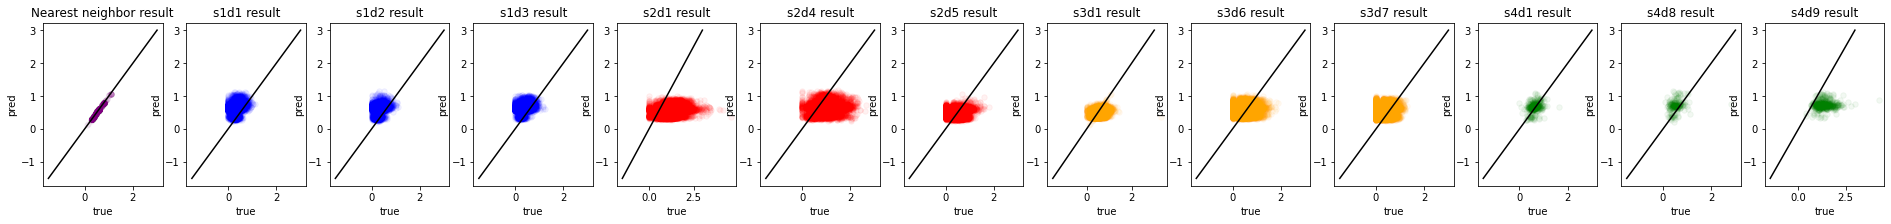

Epoch  33100 near loss: 0.00079244736 s1d1:  0.3920772 s1d2:  0.37764296 s1d3:  0.35643542 s2d1: 0.80889976 s2d4: 0.55475324 s2d5: 0.3323959 s3d1: 0.2055543 s3d6: 0.34175497 s3d7: 0.3199687 s4d1: 0.20459574 s4d8: 0.3230493 s4d9: 0.74805206 test loss: 0.5407696587938619
Epoch  33200 near loss: 0.0008575621 s1d1:  0.3930848 s1d2:  0.3787302 s1d3:  0.35744578 s2d1: 0.8082762 s2d4: 0.5542661 s2d5: 0.3328273 s3d1: 0.20550507 s3d6: 0.34211892 s3d7: 0.3204289 s4d1: 0.2051883 s4d8: 0.3242944 s4d9: 0.74667186 test loss: 0.5401229805476012
Epoch  33300 near loss: 0.0006175117 s1d1:  0.39248 s1d2:  0.37794426 s1d3:  0.3567685 s2d1: 0.80881405 s2d4: 0.554772 s2d5: 0.33258143 s3d1: 0.20568311 s3d6: 0.34205312 s3d7: 0.3200867 s4d1: 0.20507444 s4d8: 0.3239629 s4d9: 0.74759775 test loss: 0.5406549685777058
Epoch  33400 near loss: 0.0008690421 s1d1:  0.39193758 s1d2:  0.37758014 s1d3:  0.35621947 s2d1: 0.8090448 s2d4: 0.5548774 s2d5: 0.33241138 s3d1: 0.20562154 s3d6: 0.34177554 s3d7: 0.319941 s4d1: 0.2

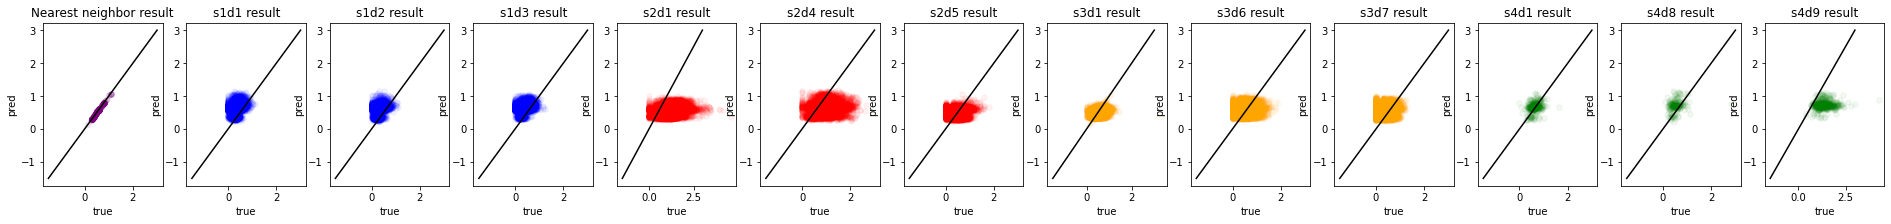

Epoch  34100 near loss: 0.0008307869 s1d1:  0.39168856 s1d2:  0.37710834 s1d3:  0.35596284 s2d1: 0.8091636 s2d4: 0.55508333 s2d5: 0.33230945 s3d1: 0.2056147 s3d6: 0.34170666 s3d7: 0.31978768 s4d1: 0.20455927 s4d8: 0.32275468 s4d9: 0.74858683 test loss: 0.541068224247009
Epoch  34200 near loss: 0.0008463729 s1d1:  0.39173946 s1d2:  0.37735316 s1d3:  0.35614163 s2d1: 0.8090526 s2d4: 0.5550612 s2d5: 0.33247903 s3d1: 0.20558546 s3d6: 0.341781 s3d7: 0.31984472 s4d1: 0.20461825 s4d8: 0.32280478 s4d9: 0.7482169 test loss: 0.5408469701432949
Epoch  34300 near loss: 0.0013710506 s1d1:  0.39053088 s1d2:  0.37586424 s1d3:  0.35495317 s2d1: 0.8097458 s2d4: 0.5555949 s2d5: 0.33203077 s3d1: 0.20569745 s3d6: 0.34144273 s3d7: 0.3193314 s4d1: 0.20417711 s4d8: 0.32205138 s4d9: 0.74949443 test loss: 0.5415097913499662
Epoch  34400 near loss: 0.00066580303 s1d1:  0.39179143 s1d2:  0.3772767 s1d3:  0.35624167 s2d1: 0.80900323 s2d4: 0.55505365 s2d5: 0.33254796 s3d1: 0.2056013 s3d6: 0.34196785 s3d7: 0.320003

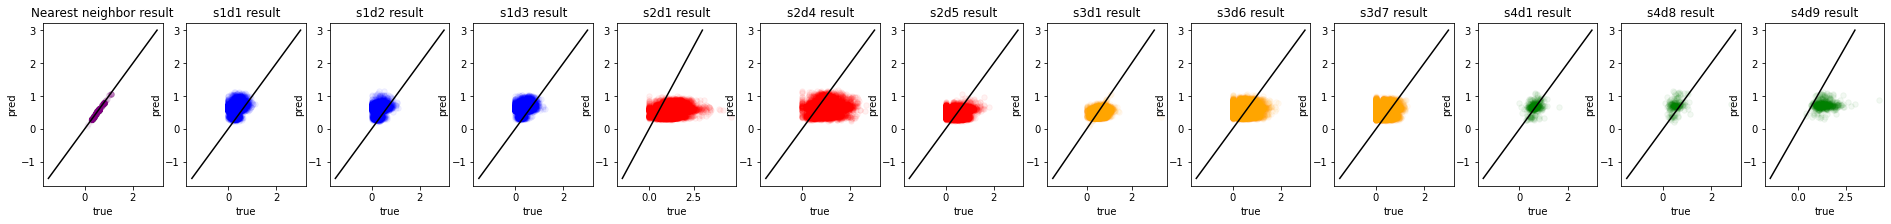

Epoch  35100 near loss: 0.00054687477 s1d1:  0.39172387 s1d2:  0.37712538 s1d3:  0.35619456 s2d1: 0.80895835 s2d4: 0.55506134 s2d5: 0.33251998 s3d1: 0.20555675 s3d6: 0.34189928 s3d7: 0.31993377 s4d1: 0.20483603 s4d8: 0.3229511 s4d9: 0.74810034 test loss: 0.5408185551533194
Epoch  35200 near loss: 0.0007923557 s1d1:  0.3925646 s1d2:  0.37747902 s1d3:  0.35693982 s2d1: 0.80857664 s2d4: 0.55456746 s2d5: 0.33248416 s3d1: 0.20550224 s3d6: 0.34203324 s3d7: 0.3201505 s4d1: 0.20499198 s4d8: 0.32330754 s4d9: 0.747653 test loss: 0.5405983850096405
Epoch  35300 near loss: 0.0015438691 s1d1:  0.39019164 s1d2:  0.375555 s1d3:  0.3547758 s2d1: 0.80994135 s2d4: 0.5557851 s2d5: 0.33201903 s3d1: 0.20571187 s3d6: 0.3413322 s3d7: 0.3191103 s4d1: 0.20406617 s4d8: 0.32126257 s4d9: 0.74990594 test loss: 0.5416603175572139
Epoch  35400 near loss: 0.0012417196 s1d1:  0.39025655 s1d2:  0.37562484 s1d3:  0.3547849 s2d1: 0.80982566 s2d4: 0.55569804 s2d5: 0.3320206 s3d1: 0.2056869 s3d6: 0.34138003 s3d7: 0.3192039

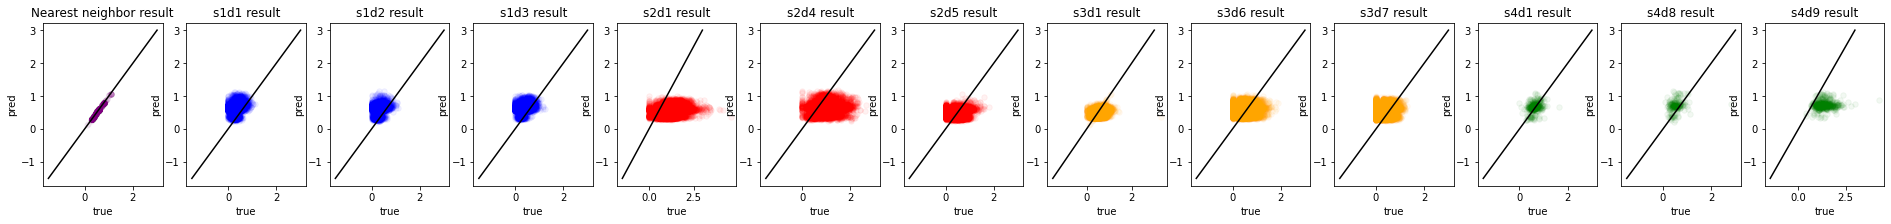

Epoch  36100 near loss: 0.001145994 s1d1:  0.39309675 s1d2:  0.37857425 s1d3:  0.3573906 s2d1: 0.80813503 s2d4: 0.55427974 s2d5: 0.33290425 s3d1: 0.20541857 s3d6: 0.342276 s3d7: 0.32059494 s4d1: 0.20537014 s4d8: 0.3243699 s4d9: 0.7464433 test loss: 0.5400104205450085
Epoch  36200 near loss: 0.00069819787 s1d1:  0.39184746 s1d2:  0.37759387 s1d3:  0.35619193 s2d1: 0.8090873 s2d4: 0.55489445 s2d5: 0.33252156 s3d1: 0.2055553 s3d6: 0.34176424 s3d7: 0.31992665 s4d1: 0.20476122 s4d8: 0.32315475 s4d9: 0.7478295 test loss: 0.5406623307745991
Epoch  36300 near loss: 0.001166229 s1d1:  0.3929913 s1d2:  0.3782284 s1d3:  0.3573235 s2d1: 0.8085014 s2d4: 0.55454016 s2d5: 0.3327571 s3d1: 0.2055364 s3d6: 0.34225783 s3d7: 0.3203822 s4d1: 0.20537241 s4d8: 0.32417923 s4d9: 0.7469444 test loss: 0.5403050137136893
Epoch  36400 near loss: 0.0015473191 s1d1:  0.39365557 s1d2:  0.3791385 s1d3:  0.3579601 s2d1: 0.8077837 s2d4: 0.5539217 s2d5: 0.33298296 s3d1: 0.20532757 s3d6: 0.34238863 s3d7: 0.32087404 s4d1: 

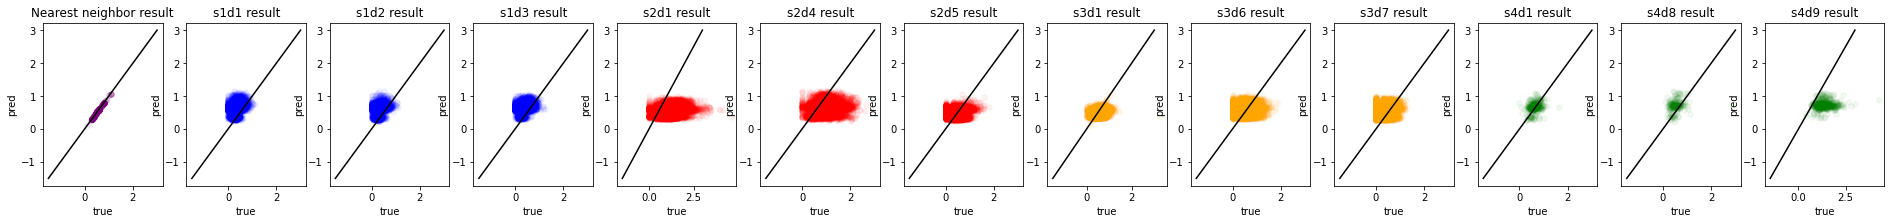

Epoch  37100 near loss: 0.0005886632 s1d1:  0.39258713 s1d2:  0.37794966 s1d3:  0.35683712 s2d1: 0.8086206 s2d4: 0.55463296 s2d5: 0.33258486 s3d1: 0.20549014 s3d6: 0.34199297 s3d7: 0.32017285 s4d1: 0.20490056 s4d8: 0.3235841 s4d9: 0.7476279 test loss: 0.5406051446942712
Epoch  37200 near loss: 0.00056866376 s1d1:  0.39175725 s1d2:  0.37724295 s1d3:  0.356231 s2d1: 0.80918837 s2d4: 0.5550598 s2d5: 0.3324544 s3d1: 0.2056415 s3d6: 0.34184176 s3d7: 0.31983948 s4d1: 0.20485005 s4d8: 0.32316267 s4d9: 0.74816513 test loss: 0.5408876135346367
Epoch  37300 near loss: 0.0011052295 s1d1:  0.39055088 s1d2:  0.37625974 s1d3:  0.3551539 s2d1: 0.8098904 s2d4: 0.5556279 s2d5: 0.33222878 s3d1: 0.20575939 s3d6: 0.3415122 s3d7: 0.31935918 s4d1: 0.2044135 s4d8: 0.32234403 s4d9: 0.74931335 test loss: 0.541460606383989
Epoch  37400 near loss: 0.0005259837 s1d1:  0.39119756 s1d2:  0.37683177 s1d3:  0.35587022 s2d1: 0.80968404 s2d4: 0.5556027 s2d5: 0.33252093 s3d1: 0.20580196 s3d6: 0.34178346 s3d7: 0.31951624

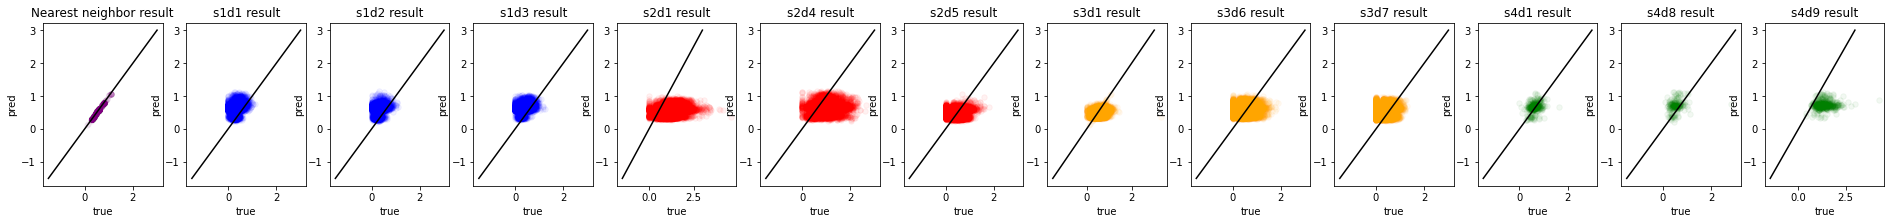

Epoch  38100 near loss: 0.0011410216 s1d1:  0.39055145 s1d2:  0.37589812 s1d3:  0.35513726 s2d1: 0.80988365 s2d4: 0.55563116 s2d5: 0.33199462 s3d1: 0.20572895 s3d6: 0.3414038 s3d7: 0.31922856 s4d1: 0.20422818 s4d8: 0.32191333 s4d9: 0.74972135 test loss: 0.5416434076929079
Epoch  38200 near loss: 0.0008681977 s1d1:  0.39150056 s1d2:  0.3768131 s1d3:  0.35599425 s2d1: 0.8093631 s2d4: 0.5551389 s2d5: 0.33223656 s3d1: 0.20562986 s3d6: 0.34158295 s3d7: 0.3195727 s4d1: 0.20445572 s4d8: 0.32229033 s4d9: 0.7488463 test loss: 0.5411626354539547
Epoch  38300 near loss: 0.001030521 s1d1:  0.39148748 s1d2:  0.37710074 s1d3:  0.3559478 s2d1: 0.80930644 s2d4: 0.55514663 s2d5: 0.3323244 s3d1: 0.20563103 s3d6: 0.34163466 s3d7: 0.31962717 s4d1: 0.20456584 s4d8: 0.322516 s4d9: 0.74869466 test loss: 0.5411080787104298
Epoch  38400 near loss: 0.0005105058 s1d1:  0.39213684 s1d2:  0.37805232 s1d3:  0.35663676 s2d1: 0.8089432 s2d4: 0.5547264 s2d5: 0.3326531 s3d1: 0.20554975 s3d6: 0.34189358 s3d7: 0.3201121 

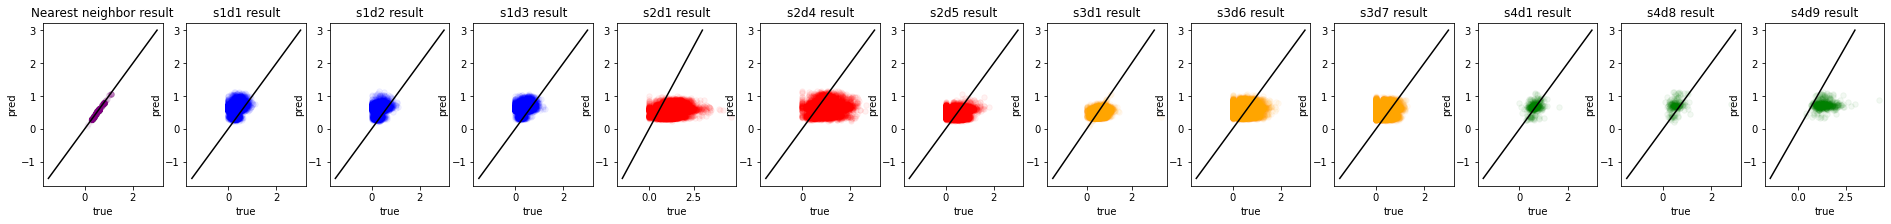

Epoch  39100 near loss: 0.00073186366 s1d1:  0.39226994 s1d2:  0.37781394 s1d3:  0.35680926 s2d1: 0.8087895 s2d4: 0.5548001 s2d5: 0.3326835 s3d1: 0.20552889 s3d6: 0.34193203 s3d7: 0.32005033 s4d1: 0.20494127 s4d8: 0.32309303 s4d9: 0.7477304 test loss: 0.5406145291747703
Epoch  39200 near loss: 0.00061016314 s1d1:  0.39239126 s1d2:  0.37781832 s1d3:  0.35689843 s2d1: 0.80851424 s2d4: 0.55460787 s2d5: 0.3326466 s3d1: 0.20547187 s3d6: 0.3420114 s3d7: 0.32021362 s4d1: 0.20500848 s4d8: 0.32340297 s4d9: 0.74756116 test loss: 0.5405539868963845
Epoch  39300 near loss: 0.0007416058 s1d1:  0.39215443 s1d2:  0.3777273 s1d3:  0.35662726 s2d1: 0.8085885 s2d4: 0.5545817 s2d5: 0.33265746 s3d1: 0.20544675 s3d6: 0.34192064 s3d7: 0.32021257 s4d1: 0.2050329 s4d8: 0.32346016 s4d9: 0.7474658 test loss: 0.5405036290798024
Epoch  39400 near loss: 0.0019212831 s1d1:  0.3933134 s1d2:  0.37904003 s1d3:  0.35777417 s2d1: 0.8079083 s2d4: 0.5541709 s2d5: 0.3331762 s3d1: 0.2053464 s3d6: 0.34232232 s3d7: 0.32076806

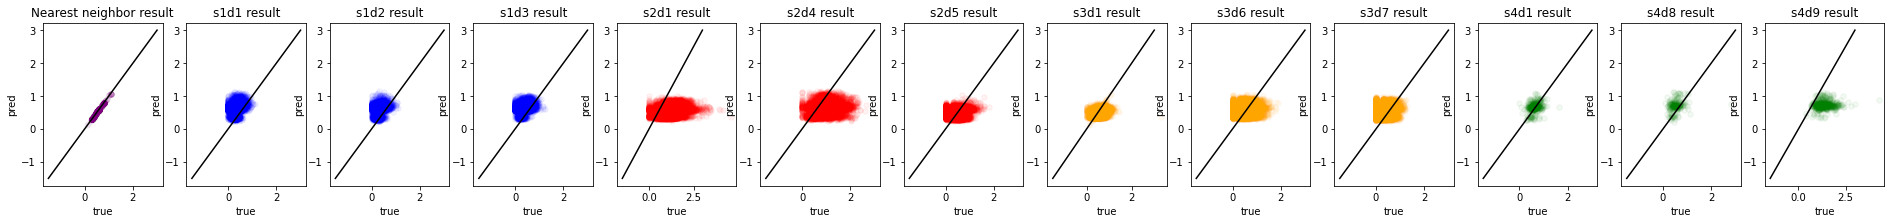

Epoch  40100 near loss: 0.0007236244 s1d1:  0.39153114 s1d2:  0.3771736 s1d3:  0.35621768 s2d1: 0.80907804 s2d4: 0.55504745 s2d5: 0.33255354 s3d1: 0.20553675 s3d6: 0.3416834 s3d7: 0.31977707 s4d1: 0.20474765 s4d8: 0.32253838 s4d9: 0.7484435 test loss: 0.5409742998597414
Epoch  40200 near loss: 0.00073875836 s1d1:  0.39123398 s1d2:  0.3770038 s1d3:  0.3557953 s2d1: 0.8092857 s2d4: 0.5552159 s2d5: 0.3324048 s3d1: 0.20557562 s3d6: 0.3416357 s3d7: 0.31971648 s4d1: 0.20463954 s4d8: 0.3226852 s4d9: 0.7487361 test loss: 0.5411645586783914
Epoch  40300 near loss: 0.00061692053 s1d1:  0.3923385 s1d2:  0.3782701 s1d3:  0.35686225 s2d1: 0.8087811 s2d4: 0.5547409 s2d5: 0.3327526 s3d1: 0.20551777 s3d6: 0.34196082 s3d7: 0.3201915 s4d1: 0.20518865 s4d8: 0.32384893 s4d9: 0.74727696 test loss: 0.5404517219319781
Epoch  40400 near loss: 0.0008808333 s1d1:  0.39129433 s1d2:  0.3768842 s1d3:  0.3558281 s2d1: 0.8093078 s2d4: 0.55509835 s2d5: 0.33230022 s3d1: 0.20557213 s3d6: 0.34161088 s3d7: 0.31967393 s4d

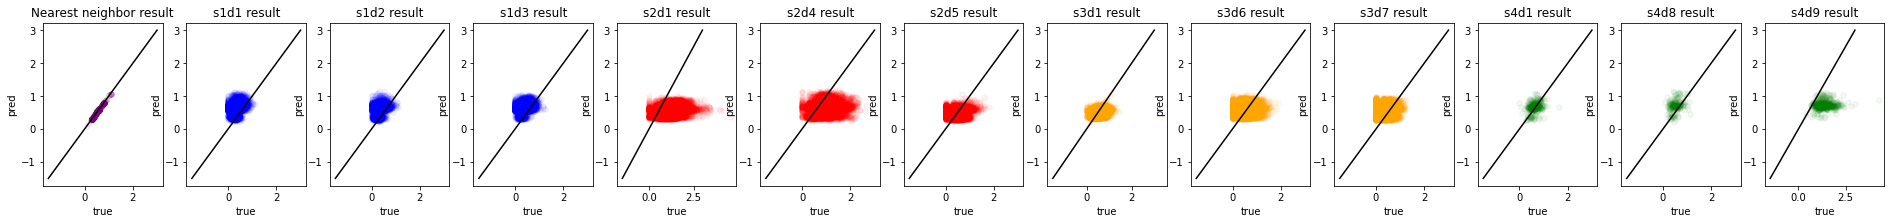

Epoch  41100 near loss: 0.0012170959 s1d1:  0.3901949 s1d2:  0.3756784 s1d3:  0.3549126 s2d1: 0.8100514 s2d4: 0.5558253 s2d5: 0.3321814 s3d1: 0.20574908 s3d6: 0.34133375 s3d7: 0.31910217 s4d1: 0.20428066 s4d8: 0.32174024 s4d9: 0.74976504 test loss: 0.5416564830745856
Epoch  41200 near loss: 0.000793618 s1d1:  0.39147255 s1d2:  0.37713495 s1d3:  0.35612226 s2d1: 0.8090286 s2d4: 0.55495626 s2d5: 0.33253422 s3d1: 0.20548181 s3d6: 0.3416614 s3d7: 0.31983492 s4d1: 0.20469393 s4d8: 0.32265404 s4d9: 0.748248 test loss: 0.5408576178780468
Epoch  41300 near loss: 0.000915454 s1d1:  0.39115006 s1d2:  0.37662205 s1d3:  0.3557935 s2d1: 0.8091914 s2d4: 0.5551211 s2d5: 0.3323892 s3d1: 0.20549482 s3d6: 0.34155315 s3d7: 0.31968728 s4d1: 0.20451832 s4d8: 0.3222435 s4d9: 0.74867904 test loss: 0.5410585381740791
Epoch  41400 near loss: 0.00071736955 s1d1:  0.39185387 s1d2:  0.37707043 s1d3:  0.35644504 s2d1: 0.80890214 s2d4: 0.55502975 s2d5: 0.33260313 s3d1: 0.2055218 s3d6: 0.34182927 s3d7: 0.31989524 s4

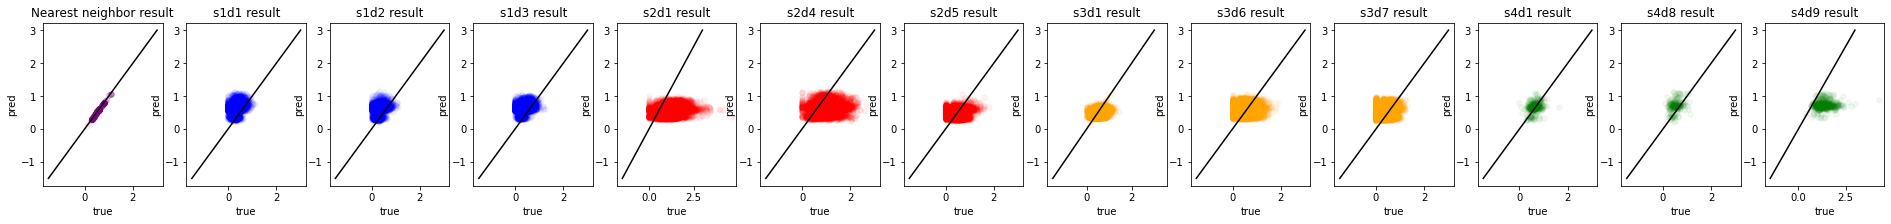

Epoch  42100 near loss: 0.0006523739 s1d1:  0.39134818 s1d2:  0.37667736 s1d3:  0.35598654 s2d1: 0.8091162 s2d4: 0.55520535 s2d5: 0.33249313 s3d1: 0.20558684 s3d6: 0.34169796 s3d7: 0.31969786 s4d1: 0.20467636 s4d8: 0.32245013 s4d9: 0.74854404 test loss: 0.541018246757958
Epoch  42200 near loss: 0.0009351254 s1d1:  0.3924021 s1d2:  0.37791663 s1d3:  0.35696614 s2d1: 0.8084463 s2d4: 0.55459195 s2d5: 0.33283144 s3d1: 0.20546703 s3d6: 0.34200805 s3d7: 0.32030094 s4d1: 0.20521094 s4d8: 0.32366756 s4d9: 0.74714667 test loss: 0.5403493563785494
Epoch  42300 near loss: 0.0012047426 s1d1:  0.39284685 s1d2:  0.37847543 s1d3:  0.3572224 s2d1: 0.8080754 s2d4: 0.55414796 s2d5: 0.3328547 s3d1: 0.20530744 s3d6: 0.3420683 s3d7: 0.32067463 s4d1: 0.20527105 s4d8: 0.32411477 s4d9: 0.7466382 test loss: 0.540089812813768
Epoch  42400 near loss: 0.00091673515 s1d1:  0.39110798 s1d2:  0.37642437 s1d3:  0.35568187 s2d1: 0.80948114 s2d4: 0.5552884 s2d5: 0.3322422 s3d1: 0.20560156 s3d6: 0.34149656 s3d7: 0.31951

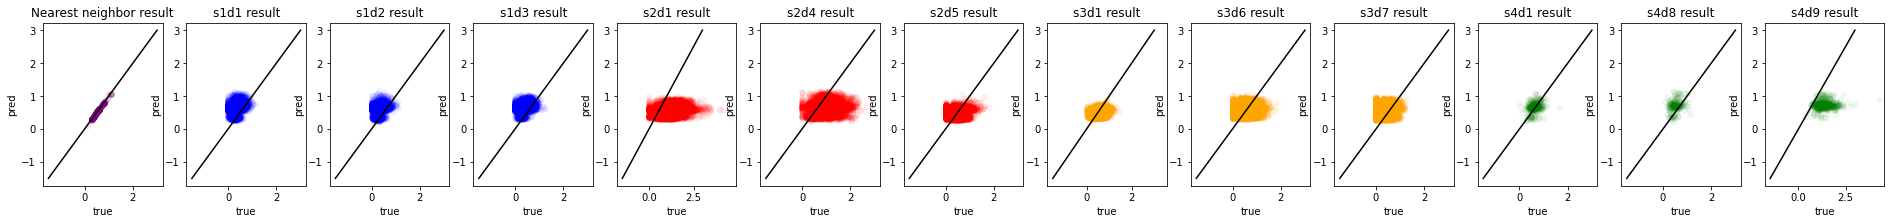

Epoch  43100 near loss: 0.0018179287 s1d1:  0.38948303 s1d2:  0.37514806 s1d3:  0.3543396 s2d1: 0.810282 s2d4: 0.55613405 s2d5: 0.33205962 s3d1: 0.20573267 s3d6: 0.34114137 s3d7: 0.31886557 s4d1: 0.20393316 s4d8: 0.32091385 s4d9: 0.7504939 test loss: 0.5419744703129208
Epoch  43200 near loss: 0.0017563308 s1d1:  0.39281383 s1d2:  0.378199 s1d3:  0.35748488 s2d1: 0.8081892 s2d4: 0.5544369 s2d5: 0.3329388 s3d1: 0.20538129 s3d6: 0.3421764 s3d7: 0.3205492 s4d1: 0.20540698 s4d8: 0.32404134 s4d9: 0.74690974 test loss: 0.5402702530913303
Epoch  43300 near loss: 0.0007268516 s1d1:  0.39076057 s1d2:  0.37638843 s1d3:  0.35538614 s2d1: 0.80979794 s2d4: 0.5557933 s2d5: 0.33235347 s3d1: 0.20573555 s3d6: 0.34161878 s3d7: 0.31945908 s4d1: 0.20466796 s4d8: 0.32240722 s4d9: 0.7490035 test loss: 0.5413037209908285
Epoch  43400 near loss: 0.0006549274 s1d1:  0.39120415 s1d2:  0.37672696 s1d3:  0.35581726 s2d1: 0.8092965 s2d4: 0.5553588 s2d5: 0.33240885 s3d1: 0.20557582 s3d6: 0.34156397 s3d7: 0.3196171 s

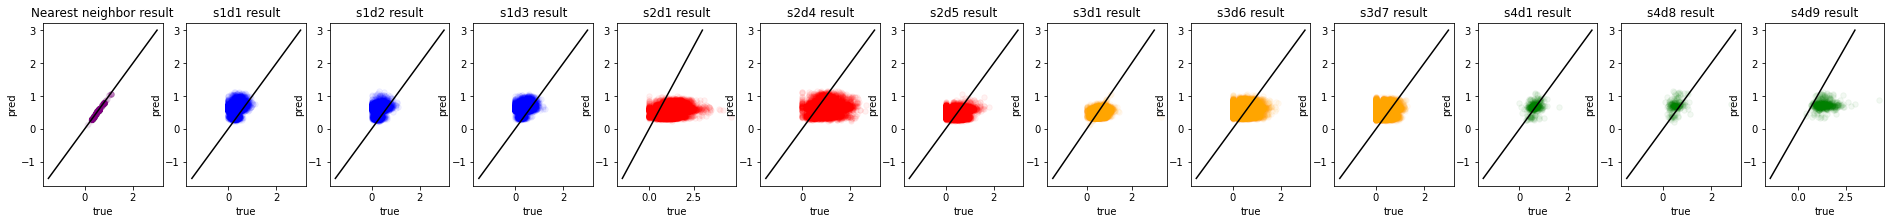

Epoch  44100 near loss: 0.0006723347 s1d1:  0.3916715 s1d2:  0.37714985 s1d3:  0.35615888 s2d1: 0.8090245 s2d4: 0.5551746 s2d5: 0.33259258 s3d1: 0.20553294 s3d6: 0.34181294 s3d7: 0.3199191 s4d1: 0.20487794 s4d8: 0.32305232 s4d9: 0.74809104 test loss: 0.5408304777874219
Epoch  44200 near loss: 0.0005276643 s1d1:  0.39156342 s1d2:  0.3770321 s1d3:  0.35608062 s2d1: 0.80912936 s2d4: 0.55518574 s2d5: 0.33251202 s3d1: 0.2055477 s3d6: 0.3417247 s3d7: 0.31979743 s4d1: 0.20480555 s4d8: 0.32282698 s4d9: 0.74826455 test loss: 0.540903639582081
Epoch  44300 near loss: 0.0009074793 s1d1:  0.39031142 s1d2:  0.37569386 s1d3:  0.3549612 s2d1: 0.80986124 s2d4: 0.55590206 s2d5: 0.33221108 s3d1: 0.20570438 s3d6: 0.3414215 s3d7: 0.31918192 s4d1: 0.20435719 s4d8: 0.32177696 s4d9: 0.74959224 test loss: 0.541560851292431
Epoch  44400 near loss: 0.0006322039 s1d1:  0.39135474 s1d2:  0.3769517 s1d3:  0.35597205 s2d1: 0.80912536 s2d4: 0.55525 s2d5: 0.33257073 s3d1: 0.20552 s3d6: 0.34171712 s3d7: 0.31981173 s4d

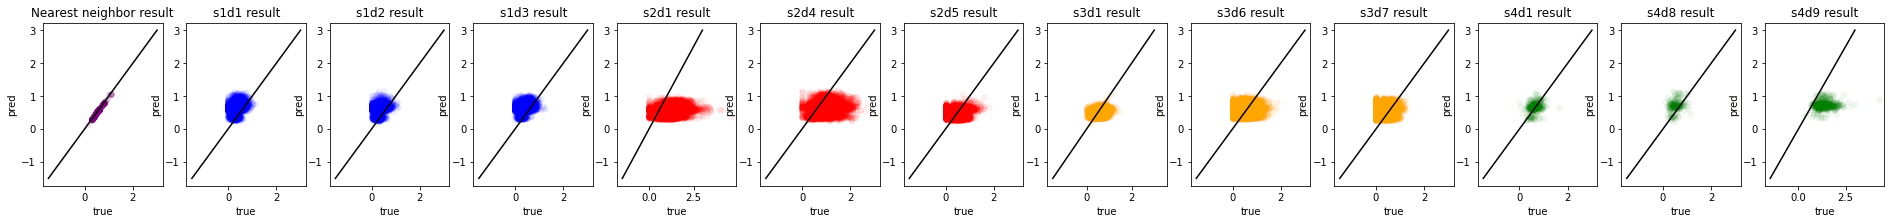

Epoch  45100 near loss: 0.0009712287 s1d1:  0.3917039 s1d2:  0.3776647 s1d3:  0.3564663 s2d1: 0.8088531 s2d4: 0.5548818 s2d5: 0.33277535 s3d1: 0.20544603 s3d6: 0.34174067 s3d7: 0.3200114 s4d1: 0.20488295 s4d8: 0.32309455 s4d9: 0.7476235 test loss: 0.5405394899335473
Epoch  45200 near loss: 0.0004915192 s1d1:  0.39153388 s1d2:  0.37701643 s1d3:  0.35619906 s2d1: 0.8091303 s2d4: 0.5552022 s2d5: 0.33255804 s3d1: 0.20555621 s3d6: 0.34176725 s3d7: 0.31975064 s4d1: 0.20487778 s4d8: 0.32275152 s4d9: 0.7481787 test loss: 0.5408489510257517
Epoch  45300 near loss: 0.00071990053 s1d1:  0.39092654 s1d2:  0.37654033 s1d3:  0.3555444 s2d1: 0.80939686 s2d4: 0.55538654 s2d5: 0.33234864 s3d1: 0.20558117 s3d6: 0.34162834 s3d7: 0.3196144 s4d1: 0.20459287 s4d8: 0.32241994 s4d9: 0.74882835 test loss: 0.5411845543707213
Epoch  45400 near loss: 0.0007369762 s1d1:  0.39015913 s1d2:  0.37559763 s1d3:  0.35489175 s2d1: 0.81003344 s2d4: 0.55599815 s2d5: 0.33224666 s3d1: 0.20574257 s3d6: 0.34142599 s3d7: 0.31909

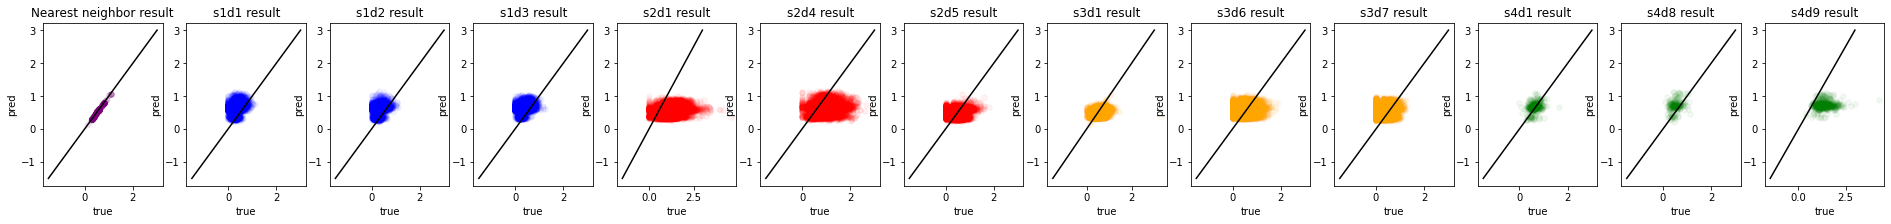

Epoch  46100 near loss: 0.00066793105 s1d1:  0.39129797 s1d2:  0.3769482 s1d3:  0.35592055 s2d1: 0.8092579 s2d4: 0.55514395 s2d5: 0.33236814 s3d1: 0.20553507 s3d6: 0.34157413 s3d7: 0.3197437 s4d1: 0.20461568 s4d8: 0.32249433 s4d9: 0.7485997 test loss: 0.541051380077683
Epoch  46200 near loss: 0.0007828449 s1d1:  0.39185566 s1d2:  0.37743583 s1d3:  0.35655975 s2d1: 0.8089599 s2d4: 0.55494124 s2d5: 0.33258906 s3d1: 0.205491 s3d6: 0.3417972 s3d7: 0.3200222 s4d1: 0.2049631 s4d8: 0.32315245 s4d9: 0.747994 test loss: 0.5407920231348146
Epoch  46300 near loss: 0.00097539596 s1d1:  0.39227268 s1d2:  0.37787396 s1d3:  0.3569896 s2d1: 0.80870193 s2d4: 0.554739 s2d5: 0.3327995 s3d1: 0.20543964 s3d6: 0.3418688 s3d7: 0.3201669 s4d1: 0.2051345 s4d8: 0.323363 s4d9: 0.7474334 test loss: 0.5404839446056805
Epoch  46400 near loss: 0.0009756549 s1d1:  0.39079243 s1d2:  0.3762391 s1d3:  0.3555214 s2d1: 0.80964386 s2d4: 0.55552745 s2d5: 0.33225647 s3d1: 0.20560761 s3d6: 0.341386 s3d7: 0.3193648 s4d1: 0.204

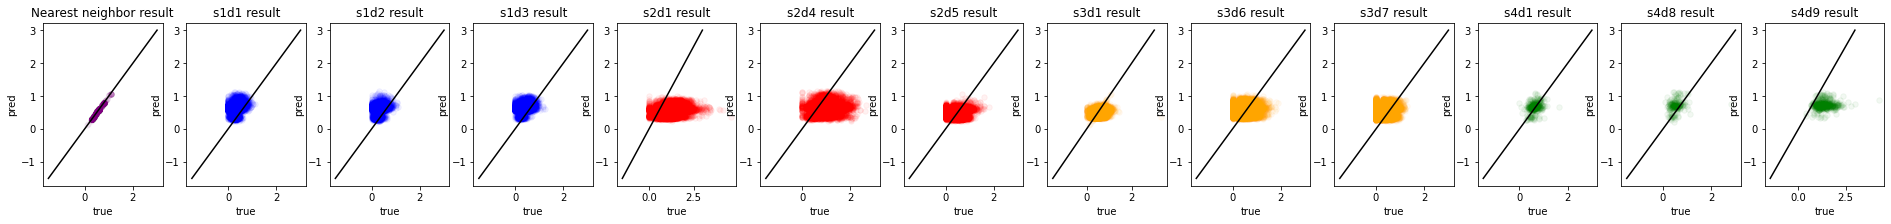

Epoch  47100 near loss: 0.0009243653 s1d1:  0.39135435 s1d2:  0.37707797 s1d3:  0.35614303 s2d1: 0.80908394 s2d4: 0.555149 s2d5: 0.33261842 s3d1: 0.20552163 s3d6: 0.3417667 s3d7: 0.3199359 s4d1: 0.20492701 s4d8: 0.32296738 s4d9: 0.74816203 test loss: 0.5408712566155609
Epoch  47200 near loss: 0.000858808 s1d1:  0.39091697 s1d2:  0.37630457 s1d3:  0.35561725 s2d1: 0.80926067 s2d4: 0.5552663 s2d5: 0.33232424 s3d1: 0.20551716 s3d6: 0.34149474 s3d7: 0.3196506 s4d1: 0.20446917 s4d8: 0.3220612 s4d9: 0.74896765 test loss: 0.5412131920075446
Epoch  47300 near loss: 0.000673974 s1d1:  0.39111188 s1d2:  0.37678054 s1d3:  0.35585964 s2d1: 0.8091667 s2d4: 0.555203 s2d5: 0.33246493 s3d1: 0.20548551 s3d6: 0.3416151 s3d7: 0.319862 s4d1: 0.20467503 s4d8: 0.32259756 s4d9: 0.7485511 test loss: 0.5410407467666155
Epoch  47400 near loss: 0.0005771534 s1d1:  0.39088395 s1d2:  0.37616703 s1d3:  0.35563245 s2d1: 0.80947405 s2d4: 0.55539703 s2d5: 0.33226568 s3d1: 0.2055317 s3d6: 0.34148428 s3d7: 0.31955144 s4

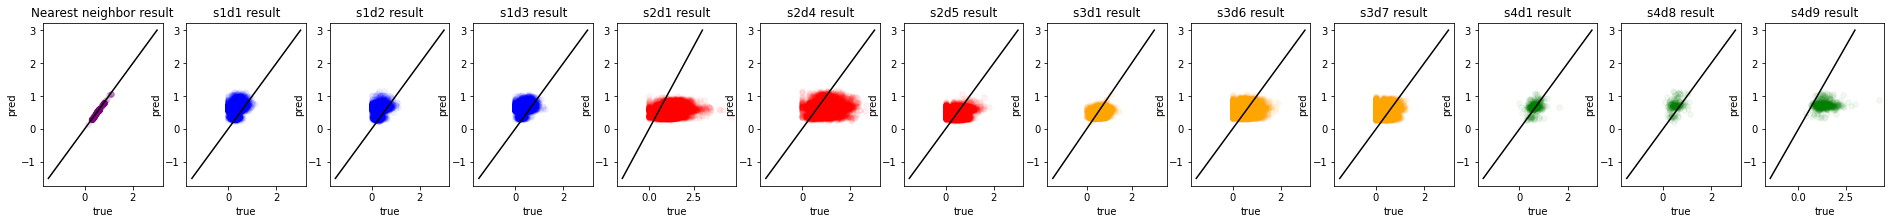

Epoch  48100 near loss: 0.0005432553 s1d1:  0.39125106 s1d2:  0.376571 s1d3:  0.35590154 s2d1: 0.8092361 s2d4: 0.5553531 s2d5: 0.3324446 s3d1: 0.20555578 s3d6: 0.341701 s3d7: 0.31971854 s4d1: 0.20487797 s4d8: 0.3225759 s4d9: 0.7488002 test loss: 0.5412219450542607
Epoch  48200 near loss: 0.00061848847 s1d1:  0.39133894 s1d2:  0.37688574 s1d3:  0.35598353 s2d1: 0.8091914 s2d4: 0.5552626 s2d5: 0.33245814 s3d1: 0.20552175 s3d6: 0.3416975 s3d7: 0.31986725 s4d1: 0.20484483 s4d8: 0.32276624 s4d9: 0.74858063 test loss: 0.5411017916398788
Epoch  48300 near loss: 0.0008016213 s1d1:  0.39076915 s1d2:  0.37574264 s1d3:  0.35541677 s2d1: 0.8096064 s2d4: 0.55564785 s2d5: 0.33203286 s3d1: 0.20560536 s3d6: 0.3413962 s3d7: 0.31932732 s4d1: 0.2043809 s4d8: 0.3217394 s4d9: 0.74973834 test loss: 0.5416520402099668
Epoch  48400 near loss: 0.00061464286 s1d1:  0.39121982 s1d2:  0.37671655 s1d3:  0.35592118 s2d1: 0.8093963 s2d4: 0.5554073 s2d5: 0.3324504 s3d1: 0.2055821 s3d6: 0.34158975 s3d7: 0.31961825 s4d

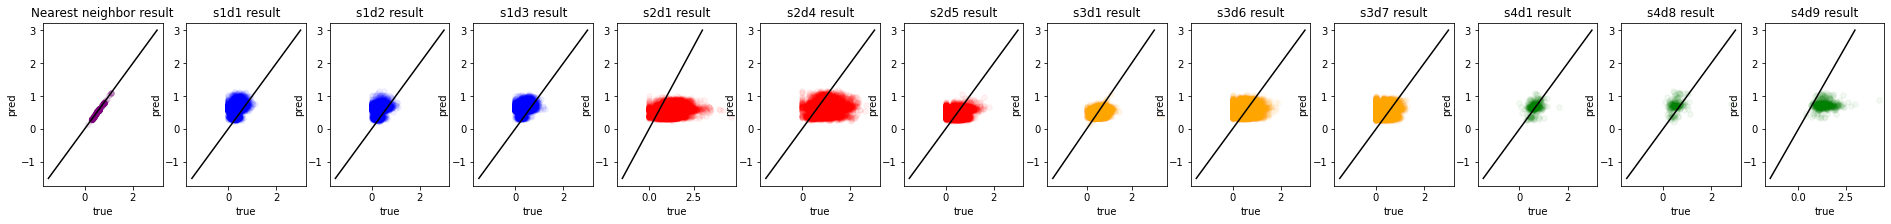

Epoch  49100 near loss: 0.0014651828 s1d1:  0.38954616 s1d2:  0.3750772 s1d3:  0.3542518 s2d1: 0.8104689 s2d4: 0.556221 s2d5: 0.3319696 s3d1: 0.20578966 s3d6: 0.34116977 s3d7: 0.31885993 s4d1: 0.20415586 s4d8: 0.3213094 s4d9: 0.75038385 test loss: 0.5419810446753643
Epoch  49200 near loss: 0.0005853157 s1d1:  0.39142448 s1d2:  0.3769514 s1d3:  0.35609725 s2d1: 0.8091994 s2d4: 0.55528903 s2d5: 0.33255488 s3d1: 0.20556311 s3d6: 0.34174624 s3d7: 0.31976363 s4d1: 0.20496112 s4d8: 0.32285127 s4d9: 0.7483418 test loss: 0.5409753527611587
Epoch  49300 near loss: 0.0007530375 s1d1:  0.39116383 s1d2:  0.37688264 s1d3:  0.35588557 s2d1: 0.80920535 s2d4: 0.555305 s2d5: 0.33253744 s3d1: 0.20553681 s3d6: 0.34165436 s3d7: 0.31970054 s4d1: 0.20483942 s4d8: 0.32262877 s4d9: 0.7485214 test loss: 0.541046515743134
Epoch  49400 near loss: 0.0007031503 s1d1:  0.39070305 s1d2:  0.37624893 s1d3:  0.35543025 s2d1: 0.809547 s2d4: 0.5556045 s2d5: 0.33233178 s3d1: 0.20557849 s3d6: 0.34143925 s3d7: 0.31939766 s4

In [42]:
num_epochs = 50000
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, input_near, output_near)